In [27]:
import scipy         
import datetime
from scipy.linalg import expm,det, logm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [28]:
L = 3 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=2
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [29]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2>           26  
      1.         |2 2 1>           25  
      2.         |2 2 0>           24  
      3.         |2 1 2>           23  
      4.         |2 1 1>           22  
      5.         |2 1 0>           21  
      6.         |2 0 2>           20  
      7.         |2 0 1>           19  
      8.         |2 0 0>           18  
      9.         |1 2 2>           17  
     10.         |1 2 1>           16  
     11.         |1 2 0>           15  
     12.         |1 1 2>           14  
     13.         |1 1 1>           13  
     14.         |1 1 0>           12  
     15.         |1 0 2>           11  
     16.         |1 0 1>           10  
     17.         |1 0 0>            9  
     18.         |0 2 2>            8  
     19.         |0 2 1>            7  
     20.         |0 2 0>            6  
     21.         |0 1 2>            5  
     22.         |0 1 1>            4  
     23.   

In [30]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [31]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [32]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [33]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [34]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [35]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [36]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [37]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [38]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [39]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-0.64551385  0.42748942  0.7       ]


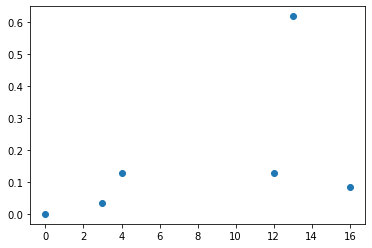

In [40]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvec[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")


In [41]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [42]:
def swap(m,n):
    swap_matrix = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    swap_matrix = sparse.csc_matrix(swap_matrix)
    for i in range(basis.Ns):
        state_m = basis.int_to_state(basis.Ns-i-1)[2*m+1]
        state_n = basis.int_to_state(basis.Ns-i-1)[2*n+1]
        string = list(basis.int_to_state(basis.Ns-i-1))
        string[2*m+1],string[2*n+1] = state_n,state_m
        string = "".join(string)
        string = string.replace(" ", "")
        string = string.replace("|","")
        string = string.replace(">", "")
        i_new = basis.Ns-1-basis.state_to_int(string)
        swap_matrix[i_new,i] = 1.
        
    return swap_matrix


def exp_gate(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)
    Matrix[8-2,8-2] = 0

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)
    Matrix[8-5,8-5] = 0

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)

    if k == 2:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3))
    if k == 0:
        Matrix_full = scipy.sparse.kron(sparse.identity(3),Matrix)
    if k == 1:
        Matrix_full = swap(1,2)@scipy.sparse.kron(Matrix,sparse.identity(3))@swap(1,2)
    return Matrix_full






                
matrix_part = 1j*logm(exp_gate(0,1).toarray()@exp_gate(1,1).toarray()@exp_gate(2,1).toarray())
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    
    return exp_gate(0,theta)@exp_gate(1,theta)@exp_gate(2,theta)


/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [43]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [44]:
def R(i,theta):
    
    if i%7 == 0:
        return(ms_gate_global(theta).toarray())
    

    
    if i%7 == 1:
        return(rot_sigma_o(0,1,0,theta).toarray())


    if i%7 == 2:
        return(rot_sigma_o(0,2,0,theta).toarray())

    
    if i%7 == 3:
        return(rot_sigma_o(1,2,np.pi/2,theta).toarray())

    if i%7 == 4:
        return(rot_sigma_r(0,1,0,theta).toarray())


    if i%7 == 5:
        return(rot_sigma_r(0,2,0,theta).toarray())

    
    if i%7 == 6:
        return(rot_sigma_r(1,2,np.pi/2,theta).toarray())
    
def S(i):
    
    if i%7 == 0:
        return(-1j*matrix_part)

    
     
    if i%7 == 1:
        return(-1j*sigma_o(0,1,0).toarray())

    
    if i%7 == 2:
        return(-1j*sigma_o(0,2,0).toarray())

    
    if i%7 == 3:
        return(-1j*sigma_o(1,2,np.pi/2).toarray())

     
    if i%7 == 4:
        return(-1j*sigma_r(0,1,0).toarray())

    
    if i%7 == 5:
        return(-1j*sigma_r(0,2,0).toarray())
    

    if i%7 == 6:
        return(-1j*sigma_r(1,2,np.pi/2).toarray())


In [45]:
coeff = 7
stepp = 1000
t_final = 10

In [46]:
matr = full_ham_matrix.toarray()
B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
psi_d = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]

In [47]:
def rhs(t,theta):
    
    print(datetime.datetime.now())
    for k in range(coeff*N):
        B[k] = R(k,theta[k])

    print("start",datetime.datetime.now())
    
    for k in range(coeff*N):
        B[k] = S(k)@R(k,theta[k])
        psi_d[k] = psi_0
        for i in range(coeff*N):
            psi_d[k] = B[i]@psi_d[k]
        B[k] = R(k,theta[k])
        
    print("stop_reduce",datetime.datetime.now())
    
    psi_conj_d = np.conj(psi_d)
    
    psi_b = psi_0
    for k in range(coeff*N):
        psi_b = B[k]@psi_b
        
    psi_conj_b = np.conj(psi_b)

    
    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)


    X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

    Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)
    
    XX = np.einsum("il,l->i",psi_conj_d,psi_b)
    
    YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)
        
    YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [48]:
time_domain = np.linspace(0, t_final, stepp)


In [49]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [50]:
#start_point = 0.001*np.ones(coeff*N)
expt_value = []
energyy = []

for kkk in range(1):
    Y = []
    start_point = np.random.rand(coeff*N)
    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

        return psi
    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))
    energy = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])

        psi_var = var_ansatz(theta,psi_0)
        for i in range(L+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
        energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)
        
    expt_value.append(expt_value_u)
    energyy.append(energy)


    

2022-08-09 19:55:04.821854
start 2022-08-09 19:55:04.908697
stop_reduce 2022-08-09 19:55:05.092689
2022-08-09 19:55:05.093427
0
2022-08-09 19:55:05.093550
start 2022-08-09 19:55:05.178547
stop_reduce 2022-08-09 19:55:05.362912
2022-08-09 19:55:05.363656
0.005
2022-08-09 19:55:05.363843
start 2022-08-09 19:55:05.455397
stop_reduce 2022-08-09 19:55:05.639758
2022-08-09 19:55:05.640375
0.005
2022-08-09 19:55:05.640440
start 2022-08-09 19:55:05.725639
stop_reduce 2022-08-09 19:55:05.914428
2022-08-09 19:55:05.915073
0.01
2022-08-09 19:55:05.915143
start 2022-08-09 19:55:06.001377
stop_reduce 2022-08-09 19:55:06.190665
2022-08-09 19:55:06.191409
0.01
2022-08-09 19:55:06.191544
start 2022-08-09 19:55:06.276281
stop_reduce 2022-08-09 19:55:06.467447
2022-08-09 19:55:06.467980
0.015
2022-08-09 19:55:06.468039
start 2022-08-09 19:55:06.555554
stop_reduce 2022-08-09 19:55:06.746623
2022-08-09 19:55:06.747305
0.015
2022-08-09 19:55:06.747351
start 2022-08-09 19:55:06.832837
stop_reduce 2022-08-09

stop_reduce 2022-08-09 19:55:21.981526
2022-08-09 19:55:21.981999
0.15
2022-08-09 19:55:21.982044
start 2022-08-09 19:55:22.066462
stop_reduce 2022-08-09 19:55:22.247754
2022-08-09 19:55:22.248195
0.155
2022-08-09 19:55:22.248239
start 2022-08-09 19:55:22.332790
stop_reduce 2022-08-09 19:55:22.514089
2022-08-09 19:55:22.514523
0.155
2022-08-09 19:55:22.514565
start 2022-08-09 19:55:22.599057
stop_reduce 2022-08-09 19:55:22.786111
2022-08-09 19:55:22.786548
0.16
2022-08-09 19:55:22.786599
start 2022-08-09 19:55:22.871416
stop_reduce 2022-08-09 19:55:23.053411
2022-08-09 19:55:23.053927
0.16
2022-08-09 19:55:23.053965
start 2022-08-09 19:55:23.138195
stop_reduce 2022-08-09 19:55:23.320623
2022-08-09 19:55:23.321120
0.165
2022-08-09 19:55:23.321264
start 2022-08-09 19:55:23.405756
stop_reduce 2022-08-09 19:55:23.587517
2022-08-09 19:55:23.588006
0.165
2022-08-09 19:55:23.588044
start 2022-08-09 19:55:23.681768
stop_reduce 2022-08-09 19:55:23.863724
2022-08-09 19:55:23.864219
0.17
2022-08-

stop_reduce 2022-08-09 19:55:43.615618
2022-08-09 19:55:43.616275
0.2950000000000001
2022-08-09 19:55:43.616333
start 2022-08-09 19:55:43.741446
stop_reduce 2022-08-09 19:55:44.015874
2022-08-09 19:55:44.016627
0.3000000000000001
2022-08-09 19:55:44.016694
start 2022-08-09 19:55:44.141678
stop_reduce 2022-08-09 19:55:44.409461
2022-08-09 19:55:44.410143
0.3000000000000001
2022-08-09 19:55:44.410202
start 2022-08-09 19:55:44.535004
stop_reduce 2022-08-09 19:55:44.809267
2022-08-09 19:55:44.810107
0.3050000000000001
2022-08-09 19:55:44.810203
start 2022-08-09 19:55:44.938749
stop_reduce 2022-08-09 19:55:45.210125
2022-08-09 19:55:45.210834
0.3050000000000001
2022-08-09 19:55:45.210900
start 2022-08-09 19:55:45.335813
stop_reduce 2022-08-09 19:55:45.604233
2022-08-09 19:55:45.604951
0.3100000000000001
2022-08-09 19:55:45.605025
start 2022-08-09 19:55:45.730265
stop_reduce 2022-08-09 19:55:46.004183
2022-08-09 19:55:46.004892
0.3100000000000001
2022-08-09 19:55:46.004965
start 2022-08-09 1

stop_reduce 2022-08-09 19:56:04.977952
2022-08-09 19:56:04.978632
0.4400000000000002
2022-08-09 19:56:04.978693
start 2022-08-09 19:56:05.094909
stop_reduce 2022-08-09 19:56:05.349465
2022-08-09 19:56:05.350119
0.4400000000000002
2022-08-09 19:56:05.350177
start 2022-08-09 19:56:05.466011
stop_reduce 2022-08-09 19:56:05.714677
2022-08-09 19:56:05.715342
0.44500000000000023
2022-08-09 19:56:05.715399
start 2022-08-09 19:56:05.831183
stop_reduce 2022-08-09 19:56:06.077950
2022-08-09 19:56:06.078700
0.44500000000000023
2022-08-09 19:56:06.078754
start 2022-08-09 19:56:06.200468
stop_reduce 2022-08-09 19:56:06.447595
2022-08-09 19:56:06.448285
0.45000000000000023
2022-08-09 19:56:06.448343
start 2022-08-09 19:56:06.562565
stop_reduce 2022-08-09 19:56:06.810970
2022-08-09 19:56:06.811705
0.45000000000000023
2022-08-09 19:56:06.811762
start 2022-08-09 19:56:06.925846
stop_reduce 2022-08-09 19:56:07.176755
2022-08-09 19:56:07.177702
0.45500000000000024
2022-08-09 19:56:07.177758
start 2022-08

stop_reduce 2022-08-09 19:56:25.837387
2022-08-09 19:56:25.838054
0.5800000000000003
2022-08-09 19:56:25.838110
start 2022-08-09 19:56:25.954051
stop_reduce 2022-08-09 19:56:26.202771
2022-08-09 19:56:26.203446
0.5850000000000003
2022-08-09 19:56:26.203506
start 2022-08-09 19:56:26.319373
stop_reduce 2022-08-09 19:56:26.567993
2022-08-09 19:56:26.568669
0.5850000000000003
2022-08-09 19:56:26.568726
start 2022-08-09 19:56:26.684804
stop_reduce 2022-08-09 19:56:26.931646
2022-08-09 19:56:26.932292
0.5900000000000003
2022-08-09 19:56:26.932359
start 2022-08-09 19:56:27.048007
stop_reduce 2022-08-09 19:56:27.295729
2022-08-09 19:56:27.296343
0.5900000000000003
2022-08-09 19:56:27.296407
start 2022-08-09 19:56:27.412633
stop_reduce 2022-08-09 19:56:27.661590
2022-08-09 19:56:27.662241
0.5950000000000003
2022-08-09 19:56:27.662306
start 2022-08-09 19:56:27.776873
stop_reduce 2022-08-09 19:56:28.025178
2022-08-09 19:56:28.025776
0.5950000000000003
2022-08-09 19:56:28.025838
start 2022-08-09 1

stop_reduce 2022-08-09 19:56:46.747245
2022-08-09 19:56:46.747896
0.7250000000000004
2022-08-09 19:56:46.747954
start 2022-08-09 19:56:46.864138
stop_reduce 2022-08-09 19:56:47.113580
2022-08-09 19:56:47.114216
0.7250000000000004
2022-08-09 19:56:47.114274
start 2022-08-09 19:56:47.230650
stop_reduce 2022-08-09 19:56:47.480707
2022-08-09 19:56:47.481361
0.7300000000000004
2022-08-09 19:56:47.481426
start 2022-08-09 19:56:47.597983
stop_reduce 2022-08-09 19:56:47.850785
2022-08-09 19:56:47.851446
0.7300000000000004
2022-08-09 19:56:47.851502
start 2022-08-09 19:56:47.966241
stop_reduce 2022-08-09 19:56:48.216153
2022-08-09 19:56:48.216810
0.7350000000000004
2022-08-09 19:56:48.216866
start 2022-08-09 19:56:48.331935
stop_reduce 2022-08-09 19:56:48.581065
2022-08-09 19:56:48.581712
0.7350000000000004
2022-08-09 19:56:48.581899
start 2022-08-09 19:56:48.701724
stop_reduce 2022-08-09 19:56:48.950262
2022-08-09 19:56:48.950977
0.7400000000000004
2022-08-09 19:56:48.951041
start 2022-08-09 1

stop_reduce 2022-08-09 19:57:07.831211
2022-08-09 19:57:07.831874
0.8650000000000005
2022-08-09 19:57:07.831934
start 2022-08-09 19:57:07.953393
stop_reduce 2022-08-09 19:57:08.214138
2022-08-09 19:57:08.214795
0.8700000000000006
2022-08-09 19:57:08.214868
start 2022-08-09 19:57:08.331112
stop_reduce 2022-08-09 19:57:08.578916
2022-08-09 19:57:08.579560
0.8700000000000006
2022-08-09 19:57:08.579725
start 2022-08-09 19:57:08.694530
stop_reduce 2022-08-09 19:57:08.950323
2022-08-09 19:57:08.950994
0.8750000000000006
2022-08-09 19:57:08.951052
start 2022-08-09 19:57:09.065319
stop_reduce 2022-08-09 19:57:09.313382
2022-08-09 19:57:09.314064
0.8750000000000006
2022-08-09 19:57:09.314120
start 2022-08-09 19:57:09.430479
stop_reduce 2022-08-09 19:57:09.678554
2022-08-09 19:57:09.679206
0.8800000000000006
2022-08-09 19:57:09.679267
start 2022-08-09 19:57:09.796021
stop_reduce 2022-08-09 19:57:10.050695
2022-08-09 19:57:10.051433
0.8800000000000006
2022-08-09 19:57:10.051494
start 2022-08-09 1

stop_reduce 2022-08-09 19:57:28.807895
2022-08-09 19:57:28.808578
1.0100000000000007
2022-08-09 19:57:28.808639
start 2022-08-09 19:57:28.924642
stop_reduce 2022-08-09 19:57:29.172309
2022-08-09 19:57:29.173032
1.0100000000000007
2022-08-09 19:57:29.173094
start 2022-08-09 19:57:29.288840
stop_reduce 2022-08-09 19:57:29.537180
2022-08-09 19:57:29.537854
1.0150000000000006
2022-08-09 19:57:29.537911
start 2022-08-09 19:57:29.654204
stop_reduce 2022-08-09 19:57:29.903013
2022-08-09 19:57:29.903693
1.0150000000000006
2022-08-09 19:57:29.903746
start 2022-08-09 19:57:30.019590
stop_reduce 2022-08-09 19:57:30.271021
2022-08-09 19:57:30.271695
1.0200000000000007
2022-08-09 19:57:30.271759
start 2022-08-09 19:57:30.388078
stop_reduce 2022-08-09 19:57:30.636547
2022-08-09 19:57:30.637216
1.0200000000000007
2022-08-09 19:57:30.637272
start 2022-08-09 19:57:30.753855
stop_reduce 2022-08-09 19:57:31.004285
2022-08-09 19:57:31.005007
1.0250000000000006
2022-08-09 19:57:31.005064
start 2022-08-09 1

stop_reduce 2022-08-09 19:57:49.708472
2022-08-09 19:57:49.709136
1.1500000000000008
2022-08-09 19:57:49.709208
start 2022-08-09 19:57:49.823478
stop_reduce 2022-08-09 19:57:50.072524
2022-08-09 19:57:50.073159
1.1550000000000007
2022-08-09 19:57:50.073222
start 2022-08-09 19:57:50.187746
stop_reduce 2022-08-09 19:57:50.435629
2022-08-09 19:57:50.436279
1.1550000000000007
2022-08-09 19:57:50.436339
start 2022-08-09 19:57:50.555762
stop_reduce 2022-08-09 19:57:50.802643
2022-08-09 19:57:50.803262
1.1600000000000008
2022-08-09 19:57:50.803334
start 2022-08-09 19:57:50.919159
stop_reduce 2022-08-09 19:57:51.166841
2022-08-09 19:57:51.167471
1.1600000000000008
2022-08-09 19:57:51.167536
start 2022-08-09 19:57:51.283126
stop_reduce 2022-08-09 19:57:51.534127
2022-08-09 19:57:51.534775
1.1650000000000007
2022-08-09 19:57:51.534846
start 2022-08-09 19:57:51.650994
stop_reduce 2022-08-09 19:57:51.898159
2022-08-09 19:57:51.898772
1.1650000000000007
2022-08-09 19:57:51.898832
start 2022-08-09 1

stop_reduce 2022-08-09 19:58:10.571641
2022-08-09 19:58:10.572316
1.2950000000000008
2022-08-09 19:58:10.572373
start 2022-08-09 19:58:10.693980
stop_reduce 2022-08-09 19:58:10.941941
2022-08-09 19:58:10.942620
1.2950000000000008
2022-08-09 19:58:10.942826
start 2022-08-09 19:58:11.058658
stop_reduce 2022-08-09 19:58:11.305659
2022-08-09 19:58:11.306339
1.300000000000001
2022-08-09 19:58:11.306399
start 2022-08-09 19:58:11.421386
stop_reduce 2022-08-09 19:58:11.669529
2022-08-09 19:58:11.670171
1.300000000000001
2022-08-09 19:58:11.670240
start 2022-08-09 19:58:11.791011
stop_reduce 2022-08-09 19:58:12.040046
2022-08-09 19:58:12.040701
1.3050000000000008
2022-08-09 19:58:12.040759
start 2022-08-09 19:58:12.155128
stop_reduce 2022-08-09 19:58:12.404456
2022-08-09 19:58:12.405105
1.3050000000000008
2022-08-09 19:58:12.405159
start 2022-08-09 19:58:12.519705
stop_reduce 2022-08-09 19:58:12.775080
2022-08-09 19:58:12.775778
1.310000000000001
2022-08-09 19:58:12.775842
start 2022-08-09 19:5

stop_reduce 2022-08-09 19:58:31.277331
2022-08-09 19:58:31.277948
1.435000000000001
2022-08-09 19:58:31.278011
start 2022-08-09 19:58:31.392850
stop_reduce 2022-08-09 19:58:31.637971
2022-08-09 19:58:31.638615
1.440000000000001
2022-08-09 19:58:31.638685
start 2022-08-09 19:58:31.753637
stop_reduce 2022-08-09 19:58:32.001600
2022-08-09 19:58:32.002220
1.440000000000001
2022-08-09 19:58:32.002288
start 2022-08-09 19:58:32.117301
stop_reduce 2022-08-09 19:58:32.362313
2022-08-09 19:58:32.362919
1.445000000000001
2022-08-09 19:58:32.362984
start 2022-08-09 19:58:32.477795
stop_reduce 2022-08-09 19:58:32.732639
2022-08-09 19:58:32.733457
1.445000000000001
2022-08-09 19:58:32.733674
start 2022-08-09 19:58:32.848351
stop_reduce 2022-08-09 19:58:33.098017
2022-08-09 19:58:33.098731
1.450000000000001
2022-08-09 19:58:33.098796
start 2022-08-09 19:58:33.213412
stop_reduce 2022-08-09 19:58:33.457631
2022-08-09 19:58:33.458295
1.450000000000001
2022-08-09 19:58:33.458353
start 2022-08-09 19:58:33

stop_reduce 2022-08-09 19:58:51.987705
2022-08-09 19:58:51.988340
1.5800000000000012
2022-08-09 19:58:51.988407
start 2022-08-09 19:58:52.103946
stop_reduce 2022-08-09 19:58:52.351078
2022-08-09 19:58:52.351746
1.5800000000000012
2022-08-09 19:58:52.351804
start 2022-08-09 19:58:52.467268
stop_reduce 2022-08-09 19:58:52.715787
2022-08-09 19:58:52.716426
1.585000000000001
2022-08-09 19:58:52.716482
start 2022-08-09 19:58:52.830624
stop_reduce 2022-08-09 19:58:53.079290
2022-08-09 19:58:53.079919
1.585000000000001
2022-08-09 19:58:53.079972
start 2022-08-09 19:58:53.194456
stop_reduce 2022-08-09 19:58:53.442447
2022-08-09 19:58:53.443067
1.5900000000000012
2022-08-09 19:58:53.443129
start 2022-08-09 19:58:53.558818
stop_reduce 2022-08-09 19:58:53.807933
2022-08-09 19:58:53.808581
1.5900000000000012
2022-08-09 19:58:53.808640
start 2022-08-09 19:58:53.924347
stop_reduce 2022-08-09 19:58:54.173102
2022-08-09 19:58:54.173761
1.595000000000001
2022-08-09 19:58:54.173817
start 2022-08-09 19:5

stop_reduce 2022-08-09 19:59:13.078473
2022-08-09 19:59:13.079117
1.7200000000000013
2022-08-09 19:59:13.079320
start 2022-08-09 19:59:13.193473
stop_reduce 2022-08-09 19:59:13.442920
2022-08-09 19:59:13.443560
1.7250000000000012
2022-08-09 19:59:13.443749
start 2022-08-09 19:59:13.559685
stop_reduce 2022-08-09 19:59:13.807358
2022-08-09 19:59:13.807981
1.7250000000000012
2022-08-09 19:59:13.808036
start 2022-08-09 19:59:13.924406
stop_reduce 2022-08-09 19:59:14.171790
2022-08-09 19:59:14.172426
1.7300000000000013
2022-08-09 19:59:14.172496
start 2022-08-09 19:59:14.288143
stop_reduce 2022-08-09 19:59:14.536294
2022-08-09 19:59:14.536963
1.7300000000000013
2022-08-09 19:59:14.537019
start 2022-08-09 19:59:14.653186
stop_reduce 2022-08-09 19:59:14.900853
2022-08-09 19:59:14.901516
1.7350000000000012
2022-08-09 19:59:14.901574
start 2022-08-09 19:59:15.017370
stop_reduce 2022-08-09 19:59:15.265070
2022-08-09 19:59:15.265718
1.7350000000000012
2022-08-09 19:59:15.265772
start 2022-08-09 1

stop_reduce 2022-08-09 19:59:33.904275
2022-08-09 19:59:33.905119
1.8650000000000013
2022-08-09 19:59:33.905339
start 2022-08-09 19:59:34.020234
stop_reduce 2022-08-09 19:59:34.268144
2022-08-09 19:59:34.268804
1.8650000000000013
2022-08-09 19:59:34.268867
start 2022-08-09 19:59:34.384441
stop_reduce 2022-08-09 19:59:34.630767
2022-08-09 19:59:34.631639
1.8700000000000014
2022-08-09 19:59:34.631759
start 2022-08-09 19:59:34.757606
stop_reduce 2022-08-09 19:59:35.008177
2022-08-09 19:59:35.008987
1.8700000000000014
2022-08-09 19:59:35.009048
start 2022-08-09 19:59:35.124760
stop_reduce 2022-08-09 19:59:35.373665
2022-08-09 19:59:35.374342
1.8750000000000013
2022-08-09 19:59:35.374403
start 2022-08-09 19:59:35.490324
stop_reduce 2022-08-09 19:59:35.740736
2022-08-09 19:59:35.741450
1.8750000000000013
2022-08-09 19:59:35.741507
start 2022-08-09 19:59:35.861120
stop_reduce 2022-08-09 19:59:36.116044
2022-08-09 19:59:36.116696
1.8800000000000014
2022-08-09 19:59:36.116760
start 2022-08-09 1

stop_reduce 2022-08-09 19:59:54.796099
2022-08-09 19:59:54.796854
2.0050000000000012
2022-08-09 19:59:54.797066
start 2022-08-09 19:59:54.913325
stop_reduce 2022-08-09 19:59:55.165991
2022-08-09 19:59:55.166651
2.010000000000001
2022-08-09 19:59:55.166714
start 2022-08-09 19:59:55.282807
stop_reduce 2022-08-09 19:59:55.532701
2022-08-09 19:59:55.533378
2.010000000000001
2022-08-09 19:59:55.533435
start 2022-08-09 19:59:55.650209
stop_reduce 2022-08-09 19:59:55.900589
2022-08-09 19:59:55.901253
2.015000000000001
2022-08-09 19:59:55.901310
start 2022-08-09 19:59:56.020423
stop_reduce 2022-08-09 19:59:56.269913
2022-08-09 19:59:56.270572
2.015000000000001
2022-08-09 19:59:56.270634
start 2022-08-09 19:59:56.386261
stop_reduce 2022-08-09 19:59:56.635754
2022-08-09 19:59:56.636426
2.020000000000001
2022-08-09 19:59:56.636492
start 2022-08-09 19:59:56.752929
stop_reduce 2022-08-09 19:59:57.002301
2022-08-09 19:59:57.002996
2.020000000000001
2022-08-09 19:59:57.003051
start 2022-08-09 19:59:5

stop_reduce 2022-08-09 20:00:16.137905
2022-08-09 20:00:16.138544
2.149999999999998
2022-08-09 20:00:16.138600
start 2022-08-09 20:00:16.258217
stop_reduce 2022-08-09 20:00:16.508720
2022-08-09 20:00:16.509408
2.154999999999998
2022-08-09 20:00:16.509470
start 2022-08-09 20:00:16.625860
stop_reduce 2022-08-09 20:00:16.874842
2022-08-09 20:00:16.875491
2.154999999999998
2022-08-09 20:00:16.875547
start 2022-08-09 20:00:16.991825
stop_reduce 2022-08-09 20:00:17.243841
2022-08-09 20:00:17.244561
2.159999999999998
2022-08-09 20:00:17.244623
start 2022-08-09 20:00:17.361362
stop_reduce 2022-08-09 20:00:17.611025
2022-08-09 20:00:17.611693
2.159999999999998
2022-08-09 20:00:17.611750
start 2022-08-09 20:00:17.728152
stop_reduce 2022-08-09 20:00:17.978016
2022-08-09 20:00:17.978643
2.164999999999998
2022-08-09 20:00:17.978698
start 2022-08-09 20:00:18.094758
stop_reduce 2022-08-09 20:00:18.343465
2022-08-09 20:00:18.344105
2.164999999999998
2022-08-09 20:00:18.344159
start 2022-08-09 20:00:18

stop_reduce 2022-08-09 20:00:37.056204
2022-08-09 20:00:37.056891
2.294999999999995
2022-08-09 20:00:37.056946
start 2022-08-09 20:00:37.172548
stop_reduce 2022-08-09 20:00:37.420011
2022-08-09 20:00:37.420704
2.294999999999995
2022-08-09 20:00:37.420757
start 2022-08-09 20:00:37.540240
stop_reduce 2022-08-09 20:00:37.787618
2022-08-09 20:00:37.788291
2.299999999999995
2022-08-09 20:00:37.788351
start 2022-08-09 20:00:37.903829
stop_reduce 2022-08-09 20:00:38.151468
2022-08-09 20:00:38.152146
2.299999999999995
2022-08-09 20:00:38.152206
start 2022-08-09 20:00:38.268162
stop_reduce 2022-08-09 20:00:38.519002
2022-08-09 20:00:38.519659
2.304999999999995
2022-08-09 20:00:38.519716
start 2022-08-09 20:00:38.635893
stop_reduce 2022-08-09 20:00:38.885921
2022-08-09 20:00:38.886579
2.304999999999995
2022-08-09 20:00:38.886634
start 2022-08-09 20:00:39.002357
stop_reduce 2022-08-09 20:00:39.251168
2022-08-09 20:00:39.251839
2.3099999999999947
2022-08-09 20:00:39.251899
start 2022-08-09 20:00:3

stop_reduce 2022-08-09 20:00:58.014863
2022-08-09 20:00:58.015589
2.434999999999992
2022-08-09 20:00:58.015642
start 2022-08-09 20:00:58.134017
stop_reduce 2022-08-09 20:00:58.388051
2022-08-09 20:00:58.388705
2.439999999999992
2022-08-09 20:00:58.388775
start 2022-08-09 20:00:58.525867
stop_reduce 2022-08-09 20:00:58.776580
2022-08-09 20:00:58.777494
2.439999999999992
2022-08-09 20:00:58.777552
start 2022-08-09 20:00:58.893241
stop_reduce 2022-08-09 20:00:59.140819
2022-08-09 20:00:59.141506
2.444999999999992
2022-08-09 20:00:59.141563
start 2022-08-09 20:00:59.282403
stop_reduce 2022-08-09 20:00:59.530059
2022-08-09 20:00:59.530731
2.444999999999992
2022-08-09 20:00:59.530786
start 2022-08-09 20:00:59.646376
stop_reduce 2022-08-09 20:00:59.898570
2022-08-09 20:00:59.899259
2.4499999999999917
2022-08-09 20:00:59.899321
start 2022-08-09 20:01:00.015343
stop_reduce 2022-08-09 20:01:00.266080
2022-08-09 20:01:00.266834
2.4499999999999917
2022-08-09 20:01:00.266888
start 2022-08-09 20:01:

stop_reduce 2022-08-09 20:01:19.411814
2022-08-09 20:01:19.412467
2.579999999999989
2022-08-09 20:01:19.412659
start 2022-08-09 20:01:19.526998
stop_reduce 2022-08-09 20:01:19.777118
2022-08-09 20:01:19.777812
2.579999999999989
2022-08-09 20:01:19.777867
start 2022-08-09 20:01:19.892370
stop_reduce 2022-08-09 20:01:20.145441
2022-08-09 20:01:20.146107
2.584999999999989
2022-08-09 20:01:20.146163
start 2022-08-09 20:01:20.261358
stop_reduce 2022-08-09 20:01:20.511260
2022-08-09 20:01:20.511929
2.584999999999989
2022-08-09 20:01:20.511983
start 2022-08-09 20:01:20.628306
stop_reduce 2022-08-09 20:01:20.878023
2022-08-09 20:01:20.878691
2.5899999999999888
2022-08-09 20:01:20.878755
start 2022-08-09 20:01:20.995089
stop_reduce 2022-08-09 20:01:21.252661
2022-08-09 20:01:21.253362
2.5899999999999888
2022-08-09 20:01:21.253562
start 2022-08-09 20:01:21.367466
stop_reduce 2022-08-09 20:01:21.616206
2022-08-09 20:01:21.616875
2.5949999999999886
2022-08-09 20:01:21.616938
start 2022-08-09 20:01

stop_reduce 2022-08-09 20:01:40.621005
2022-08-09 20:01:40.621690
2.719999999999986
2022-08-09 20:01:40.621747
start 2022-08-09 20:01:40.738254
stop_reduce 2022-08-09 20:01:40.988780
2022-08-09 20:01:40.989483
2.724999999999986
2022-08-09 20:01:40.989542
start 2022-08-09 20:01:41.106057
stop_reduce 2022-08-09 20:01:41.360585
2022-08-09 20:01:41.361283
2.724999999999986
2022-08-09 20:01:41.361344
start 2022-08-09 20:01:41.477922
stop_reduce 2022-08-09 20:01:41.727560
2022-08-09 20:01:41.728215
2.7299999999999858
2022-08-09 20:01:41.728278
start 2022-08-09 20:01:41.844523
stop_reduce 2022-08-09 20:01:42.094361
2022-08-09 20:01:42.095036
2.7299999999999858
2022-08-09 20:01:42.095097
start 2022-08-09 20:01:42.211548
stop_reduce 2022-08-09 20:01:42.465134
2022-08-09 20:01:42.465790
2.7349999999999857
2022-08-09 20:01:42.465846
start 2022-08-09 20:01:42.582339
stop_reduce 2022-08-09 20:01:42.833159
2022-08-09 20:01:42.833871
2.7349999999999857
2022-08-09 20:01:42.834055
start 2022-08-09 20:0

stop_reduce 2022-08-09 20:02:01.603309
2022-08-09 20:02:01.603986
2.864999999999983
2022-08-09 20:02:01.604046
start 2022-08-09 20:02:01.718266
stop_reduce 2022-08-09 20:02:01.967168
2022-08-09 20:02:01.967824
2.864999999999983
2022-08-09 20:02:01.967874
start 2022-08-09 20:02:02.082380
stop_reduce 2022-08-09 20:02:02.331080
2022-08-09 20:02:02.331756
2.869999999999983
2022-08-09 20:02:02.331970
start 2022-08-09 20:02:02.446427
stop_reduce 2022-08-09 20:02:02.701635
2022-08-09 20:02:02.702315
2.869999999999983
2022-08-09 20:02:02.702370
start 2022-08-09 20:02:02.818343
stop_reduce 2022-08-09 20:02:03.065100
2022-08-09 20:02:03.065739
2.8749999999999827
2022-08-09 20:02:03.065794
start 2022-08-09 20:02:03.180993
stop_reduce 2022-08-09 20:02:03.428220
2022-08-09 20:02:03.428882
2.8749999999999827
2022-08-09 20:02:03.428935
start 2022-08-09 20:02:03.552989
stop_reduce 2022-08-09 20:02:03.801362
2022-08-09 20:02:03.802039
2.8799999999999826
2022-08-09 20:02:03.802100
start 2022-08-09 20:02

stop_reduce 2022-08-09 20:02:22.520694
2022-08-09 20:02:22.521342
3.00499999999998
2022-08-09 20:02:22.521396
start 2022-08-09 20:02:22.638647
stop_reduce 2022-08-09 20:02:22.892846
2022-08-09 20:02:22.893549
3.00999999999998
2022-08-09 20:02:22.893613
start 2022-08-09 20:02:23.010311
stop_reduce 2022-08-09 20:02:23.259103
2022-08-09 20:02:23.259771
3.00999999999998
2022-08-09 20:02:23.259828
start 2022-08-09 20:02:23.376566
stop_reduce 2022-08-09 20:02:23.625364
2022-08-09 20:02:23.626063
3.0149999999999797
2022-08-09 20:02:23.626119
start 2022-08-09 20:02:23.742683
stop_reduce 2022-08-09 20:02:23.999029
2022-08-09 20:02:23.999684
3.0149999999999797
2022-08-09 20:02:23.999737
start 2022-08-09 20:02:24.116376
stop_reduce 2022-08-09 20:02:24.365204
2022-08-09 20:02:24.365849
3.0199999999999796
2022-08-09 20:02:24.365912
start 2022-08-09 20:02:24.482581
stop_reduce 2022-08-09 20:02:24.731613
2022-08-09 20:02:24.732265
3.0199999999999796
2022-08-09 20:02:24.732322
start 2022-08-09 20:02:2

stop_reduce 2022-08-09 20:02:43.593757
2022-08-09 20:02:43.594386
3.149999999999977
2022-08-09 20:02:43.594455
start 2022-08-09 20:02:43.711714
stop_reduce 2022-08-09 20:02:43.961252
2022-08-09 20:02:43.961923
3.149999999999977
2022-08-09 20:02:43.962129
start 2022-08-09 20:02:44.086548
stop_reduce 2022-08-09 20:02:44.337308
2022-08-09 20:02:44.337975
3.1549999999999767
2022-08-09 20:02:44.338033
start 2022-08-09 20:02:44.453616
stop_reduce 2022-08-09 20:02:44.704193
2022-08-09 20:02:44.704839
3.1549999999999767
2022-08-09 20:02:44.704900
start 2022-08-09 20:02:44.821623
stop_reduce 2022-08-09 20:02:45.073440
2022-08-09 20:02:45.074046
3.1599999999999766
2022-08-09 20:02:45.074116
start 2022-08-09 20:02:45.191071
stop_reduce 2022-08-09 20:02:45.440002
2022-08-09 20:02:45.440626
3.1599999999999766
2022-08-09 20:02:45.440690
start 2022-08-09 20:02:45.557881
stop_reduce 2022-08-09 20:02:45.806910
2022-08-09 20:02:45.807534
3.1649999999999765
2022-08-09 20:02:45.807600
start 2022-08-09 20:

stop_reduce 2022-08-09 20:03:04.683420
2022-08-09 20:03:04.684130
3.289999999999974
2022-08-09 20:03:04.684185
start 2022-08-09 20:03:04.801851
stop_reduce 2022-08-09 20:03:05.051886
2022-08-09 20:03:05.052555
3.2949999999999737
2022-08-09 20:03:05.052613
start 2022-08-09 20:03:05.168976
stop_reduce 2022-08-09 20:03:05.423646
2022-08-09 20:03:05.424321
3.2949999999999737
2022-08-09 20:03:05.424373
start 2022-08-09 20:03:05.541637
stop_reduce 2022-08-09 20:03:05.791907
2022-08-09 20:03:05.792621
3.2999999999999736
2022-08-09 20:03:05.792685
start 2022-08-09 20:03:05.909962
stop_reduce 2022-08-09 20:03:06.159954
2022-08-09 20:03:06.160602
3.2999999999999736
2022-08-09 20:03:06.160663
start 2022-08-09 20:03:06.278039
stop_reduce 2022-08-09 20:03:06.531667
2022-08-09 20:03:06.532343
3.3049999999999735
2022-08-09 20:03:06.532400
start 2022-08-09 20:03:06.649535
stop_reduce 2022-08-09 20:03:06.898964
2022-08-09 20:03:06.899641
3.3049999999999735
2022-08-09 20:03:06.899693
start 2022-08-09 20

stop_reduce 2022-08-09 20:03:25.765996
2022-08-09 20:03:25.766637
3.4349999999999707
2022-08-09 20:03:25.766703
start 2022-08-09 20:03:25.882237
stop_reduce 2022-08-09 20:03:26.134010
2022-08-09 20:03:26.134609
3.4349999999999707
2022-08-09 20:03:26.134672
start 2022-08-09 20:03:26.251991
stop_reduce 2022-08-09 20:03:26.501943
2022-08-09 20:03:26.502572
3.4399999999999706
2022-08-09 20:03:26.502641
start 2022-08-09 20:03:26.622923
stop_reduce 2022-08-09 20:03:26.874533
2022-08-09 20:03:26.875146
3.4399999999999706
2022-08-09 20:03:26.875212
start 2022-08-09 20:03:26.992513
stop_reduce 2022-08-09 20:03:27.243705
2022-08-09 20:03:27.244315
3.4449999999999705
2022-08-09 20:03:27.244381
start 2022-08-09 20:03:27.361832
stop_reduce 2022-08-09 20:03:27.616166
2022-08-09 20:03:27.616873
3.4449999999999705
2022-08-09 20:03:27.616928
start 2022-08-09 20:03:27.783838
stop_reduce 2022-08-09 20:03:28.122229
2022-08-09 20:03:28.123166
3.4499999999999704
2022-08-09 20:03:28.123246
start 2022-08-09 2

stop_reduce 2022-08-09 20:03:47.429035
2022-08-09 20:03:47.429658
3.5749999999999678
2022-08-09 20:03:47.429711
start 2022-08-09 20:03:47.547804
stop_reduce 2022-08-09 20:03:47.803449
2022-08-09 20:03:47.803927
3.5799999999999677
2022-08-09 20:03:47.803995
start 2022-08-09 20:03:47.923750
stop_reduce 2022-08-09 20:03:48.177841
2022-08-09 20:03:48.178508
3.5799999999999677
2022-08-09 20:03:48.178565
start 2022-08-09 20:03:48.297056
stop_reduce 2022-08-09 20:03:48.551035
2022-08-09 20:03:48.551708
3.5849999999999675
2022-08-09 20:03:48.551765
start 2022-08-09 20:03:48.670497
stop_reduce 2022-08-09 20:03:48.925131
2022-08-09 20:03:48.925799
3.5849999999999675
2022-08-09 20:03:48.925853
start 2022-08-09 20:03:49.044236
stop_reduce 2022-08-09 20:03:49.299100
2022-08-09 20:03:49.299773
3.5899999999999674
2022-08-09 20:03:49.299835
start 2022-08-09 20:03:49.418419
stop_reduce 2022-08-09 20:03:49.672586
2022-08-09 20:03:49.673242
3.5899999999999674
2022-08-09 20:03:49.673303
start 2022-08-09 2

stop_reduce 2022-08-09 20:04:08.773861
2022-08-09 20:04:08.774517
3.7199999999999647
2022-08-09 20:04:08.774587
start 2022-08-09 20:04:08.892472
stop_reduce 2022-08-09 20:04:09.150660
2022-08-09 20:04:09.151356
3.7199999999999647
2022-08-09 20:04:09.151416
start 2022-08-09 20:04:09.269153
stop_reduce 2022-08-09 20:04:09.520695
2022-08-09 20:04:09.521351
3.7249999999999646
2022-08-09 20:04:09.521408
start 2022-08-09 20:04:09.639060
stop_reduce 2022-08-09 20:04:09.890938
2022-08-09 20:04:09.891586
3.7249999999999646
2022-08-09 20:04:09.891646
start 2022-08-09 20:04:10.009124
stop_reduce 2022-08-09 20:04:10.264653
2022-08-09 20:04:10.265331
3.7299999999999645
2022-08-09 20:04:10.265392
start 2022-08-09 20:04:10.383264
stop_reduce 2022-08-09 20:04:10.635598
2022-08-09 20:04:10.636259
3.7299999999999645
2022-08-09 20:04:10.636314
start 2022-08-09 20:04:10.754353
stop_reduce 2022-08-09 20:04:11.006722
2022-08-09 20:04:11.007371
3.7349999999999643
2022-08-09 20:04:11.007427
start 2022-08-09 2

stop_reduce 2022-08-09 20:04:29.935658
2022-08-09 20:04:29.936342
3.8599999999999617
2022-08-09 20:04:29.936399
start 2022-08-09 20:04:30.053270
stop_reduce 2022-08-09 20:04:30.306575
2022-08-09 20:04:30.307232
3.8649999999999616
2022-08-09 20:04:30.307294
start 2022-08-09 20:04:30.425513
stop_reduce 2022-08-09 20:04:30.678874
2022-08-09 20:04:30.679665
3.8649999999999616
2022-08-09 20:04:30.679721
start 2022-08-09 20:04:30.797719
stop_reduce 2022-08-09 20:04:31.050786
2022-08-09 20:04:31.051457
3.8699999999999615
2022-08-09 20:04:31.051517
start 2022-08-09 20:04:31.167955
stop_reduce 2022-08-09 20:04:31.421416
2022-08-09 20:04:31.422189
3.8699999999999615
2022-08-09 20:04:31.422248
start 2022-08-09 20:04:31.540321
stop_reduce 2022-08-09 20:04:31.793256
2022-08-09 20:04:31.793940
3.8749999999999614
2022-08-09 20:04:31.793997
start 2022-08-09 20:04:31.910244
stop_reduce 2022-08-09 20:04:32.163335
2022-08-09 20:04:32.164007
3.8749999999999614
2022-08-09 20:04:32.164057
start 2022-08-09 2

stop_reduce 2022-08-09 20:04:51.131838
2022-08-09 20:04:51.132446
4.004999999999959
2022-08-09 20:04:51.132515
start 2022-08-09 20:04:51.250429
stop_reduce 2022-08-09 20:04:51.501666
2022-08-09 20:04:51.502270
4.004999999999959
2022-08-09 20:04:51.502338
start 2022-08-09 20:04:51.620617
stop_reduce 2022-08-09 20:04:51.874059
2022-08-09 20:04:51.874685
4.009999999999959
2022-08-09 20:04:51.874755
start 2022-08-09 20:04:51.991088
stop_reduce 2022-08-09 20:04:52.243698
2022-08-09 20:04:52.244314
4.009999999999959
2022-08-09 20:04:52.244383
start 2022-08-09 20:04:52.362310
stop_reduce 2022-08-09 20:04:52.613059
2022-08-09 20:04:52.613654
4.014999999999959
2022-08-09 20:04:52.613721
start 2022-08-09 20:04:52.731753
stop_reduce 2022-08-09 20:04:52.985300
2022-08-09 20:04:52.985955
4.014999999999959
2022-08-09 20:04:52.986021
start 2022-08-09 20:04:53.103763
stop_reduce 2022-08-09 20:04:53.356083
2022-08-09 20:04:53.356739
4.019999999999959
2022-08-09 20:04:53.356910
start 2022-08-09 20:04:53

stop_reduce 2022-08-09 20:05:12.448905
2022-08-09 20:05:12.449565
4.144999999999956
2022-08-09 20:05:12.449618
start 2022-08-09 20:05:12.566519
stop_reduce 2022-08-09 20:05:12.818140
2022-08-09 20:05:12.818861
4.149999999999956
2022-08-09 20:05:12.818934
start 2022-08-09 20:05:12.943137
stop_reduce 2022-08-09 20:05:13.195902
2022-08-09 20:05:13.196588
4.149999999999956
2022-08-09 20:05:13.196644
start 2022-08-09 20:05:13.313758
stop_reduce 2022-08-09 20:05:13.566511
2022-08-09 20:05:13.567193
4.154999999999956
2022-08-09 20:05:13.567250
start 2022-08-09 20:05:13.687335
stop_reduce 2022-08-09 20:05:13.942635
2022-08-09 20:05:13.943317
4.154999999999956
2022-08-09 20:05:13.943496
start 2022-08-09 20:05:14.060197
stop_reduce 2022-08-09 20:05:14.310929
2022-08-09 20:05:14.311576
4.159999999999956
2022-08-09 20:05:14.311639
start 2022-08-09 20:05:14.428477
stop_reduce 2022-08-09 20:05:14.678648
2022-08-09 20:05:14.679308
4.159999999999956
2022-08-09 20:05:14.679368
start 2022-08-09 20:05:14

stop_reduce 2022-08-09 20:05:33.900916
2022-08-09 20:05:33.901572
4.289999999999953
2022-08-09 20:05:33.901640
start 2022-08-09 20:05:34.020081
stop_reduce 2022-08-09 20:05:34.274098
2022-08-09 20:05:34.274734
4.289999999999953
2022-08-09 20:05:34.274795
start 2022-08-09 20:05:34.393435
stop_reduce 2022-08-09 20:05:34.646267
2022-08-09 20:05:34.647102
4.294999999999953
2022-08-09 20:05:34.647163
start 2022-08-09 20:05:34.765716
stop_reduce 2022-08-09 20:05:35.019859
2022-08-09 20:05:35.020565
4.294999999999953
2022-08-09 20:05:35.020638
start 2022-08-09 20:05:35.139170
stop_reduce 2022-08-09 20:05:35.392744
2022-08-09 20:05:35.393428
4.299999999999953
2022-08-09 20:05:35.393601
start 2022-08-09 20:05:35.511452
stop_reduce 2022-08-09 20:05:35.766363
2022-08-09 20:05:35.767049
4.299999999999953
2022-08-09 20:05:35.767116
start 2022-08-09 20:05:35.889326
stop_reduce 2022-08-09 20:05:36.145956
2022-08-09 20:05:36.146614
4.304999999999953
2022-08-09 20:05:36.146772
start 2022-08-09 20:05:36

stop_reduce 2022-08-09 20:05:55.211511
2022-08-09 20:05:55.212167
4.42999999999995
2022-08-09 20:05:55.212331
start 2022-08-09 20:05:55.330271
stop_reduce 2022-08-09 20:05:55.583381
2022-08-09 20:05:55.584011
4.43499999999995
2022-08-09 20:05:55.584075
start 2022-08-09 20:05:55.705778
stop_reduce 2022-08-09 20:05:55.967807
2022-08-09 20:05:55.968498
4.43499999999995
2022-08-09 20:05:55.968560
start 2022-08-09 20:05:56.090725
stop_reduce 2022-08-09 20:05:56.352795
2022-08-09 20:05:56.353455
4.43999999999995
2022-08-09 20:05:56.353526
start 2022-08-09 20:05:56.474896
stop_reduce 2022-08-09 20:05:56.727961
2022-08-09 20:05:56.728570
4.43999999999995
2022-08-09 20:05:56.728635
start 2022-08-09 20:05:56.847294
stop_reduce 2022-08-09 20:05:57.100247
2022-08-09 20:05:57.100862
4.44499999999995
2022-08-09 20:05:57.100924
start 2022-08-09 20:05:57.219233
stop_reduce 2022-08-09 20:05:57.477933
2022-08-09 20:05:57.478562
4.44499999999995
2022-08-09 20:05:57.478627
start 2022-08-09 20:05:57.600237

stop_reduce 2022-08-09 20:06:16.764780
2022-08-09 20:06:16.765554
4.574999999999947
2022-08-09 20:06:16.765606
start 2022-08-09 20:06:16.887916
stop_reduce 2022-08-09 20:06:17.141865
2022-08-09 20:06:17.142522
4.574999999999947
2022-08-09 20:06:17.142583
start 2022-08-09 20:06:17.260954
stop_reduce 2022-08-09 20:06:17.514322
2022-08-09 20:06:17.514969
4.579999999999947
2022-08-09 20:06:17.515030
start 2022-08-09 20:06:17.633175
stop_reduce 2022-08-09 20:06:17.895220
2022-08-09 20:06:17.895893
4.579999999999947
2022-08-09 20:06:17.895951
start 2022-08-09 20:06:18.017931
stop_reduce 2022-08-09 20:06:18.280207
2022-08-09 20:06:18.280927
4.584999999999947
2022-08-09 20:06:18.280993
start 2022-08-09 20:06:18.403014
stop_reduce 2022-08-09 20:06:18.660117
2022-08-09 20:06:18.660903
4.584999999999947
2022-08-09 20:06:18.660960
start 2022-08-09 20:06:18.783748
stop_reduce 2022-08-09 20:06:19.046287
2022-08-09 20:06:19.046971
4.589999999999947
2022-08-09 20:06:19.047036
start 2022-08-09 20:06:19

stop_reduce 2022-08-09 20:06:38.235759
2022-08-09 20:06:38.236371
4.714999999999944
2022-08-09 20:06:38.236433
start 2022-08-09 20:06:38.354587
stop_reduce 2022-08-09 20:06:38.608240
2022-08-09 20:06:38.608961
4.719999999999944
2022-08-09 20:06:38.609022
start 2022-08-09 20:06:38.727700
stop_reduce 2022-08-09 20:06:38.984915
2022-08-09 20:06:38.985585
4.719999999999944
2022-08-09 20:06:38.985642
start 2022-08-09 20:06:39.103986
stop_reduce 2022-08-09 20:06:39.357723
2022-08-09 20:06:39.358414
4.724999999999944
2022-08-09 20:06:39.358474
start 2022-08-09 20:06:39.476439
stop_reduce 2022-08-09 20:06:39.727732
2022-08-09 20:06:39.728392
4.724999999999944
2022-08-09 20:06:39.728448
start 2022-08-09 20:06:39.846792
stop_reduce 2022-08-09 20:06:40.105249
2022-08-09 20:06:40.105907
4.729999999999944
2022-08-09 20:06:40.105969
start 2022-08-09 20:06:40.224210
stop_reduce 2022-08-09 20:06:40.477327
2022-08-09 20:06:40.478007
4.729999999999944
2022-08-09 20:06:40.478062
start 2022-08-09 20:06:40

stop_reduce 2022-08-09 20:06:59.547221
2022-08-09 20:06:59.547889
4.859999999999941
2022-08-09 20:06:59.547957
start 2022-08-09 20:06:59.666336
stop_reduce 2022-08-09 20:06:59.919654
2022-08-09 20:06:59.920300
4.859999999999941
2022-08-09 20:06:59.920467
start 2022-08-09 20:07:00.039755
stop_reduce 2022-08-09 20:07:00.299917
2022-08-09 20:07:00.300589
4.864999999999941
2022-08-09 20:07:00.300657
start 2022-08-09 20:07:00.419547
stop_reduce 2022-08-09 20:07:00.674732
2022-08-09 20:07:00.675427
4.864999999999941
2022-08-09 20:07:00.675602
start 2022-08-09 20:07:00.793869
stop_reduce 2022-08-09 20:07:01.047038
2022-08-09 20:07:01.047672
4.869999999999941
2022-08-09 20:07:01.047748
start 2022-08-09 20:07:01.172449
stop_reduce 2022-08-09 20:07:01.426137
2022-08-09 20:07:01.426767
4.869999999999941
2022-08-09 20:07:01.426832
start 2022-08-09 20:07:01.545156
stop_reduce 2022-08-09 20:07:01.798464
2022-08-09 20:07:01.799067
4.8749999999999405
2022-08-09 20:07:01.799132
start 2022-08-09 20:07:0

stop_reduce 2022-08-09 20:07:20.849303
2022-08-09 20:07:20.849945
4.999999999999938
2022-08-09 20:07:20.850011
start 2022-08-09 20:07:20.968424
stop_reduce 2022-08-09 20:07:21.221770
2022-08-09 20:07:21.222419
5.004999999999938
2022-08-09 20:07:21.222495
start 2022-08-09 20:07:21.340852
stop_reduce 2022-08-09 20:07:21.599323
2022-08-09 20:07:21.599929
5.004999999999938
2022-08-09 20:07:21.599992
start 2022-08-09 20:07:21.717651
stop_reduce 2022-08-09 20:07:21.971075
2022-08-09 20:07:21.971696
5.009999999999938
2022-08-09 20:07:21.971773
start 2022-08-09 20:07:22.088748
stop_reduce 2022-08-09 20:07:22.342299
2022-08-09 20:07:22.342913
5.009999999999938
2022-08-09 20:07:22.342982
start 2022-08-09 20:07:22.465832
stop_reduce 2022-08-09 20:07:22.719283
2022-08-09 20:07:22.720058
5.0149999999999375
2022-08-09 20:07:22.720282
start 2022-08-09 20:07:22.848001
stop_reduce 2022-08-09 20:07:23.102954
2022-08-09 20:07:23.103629
5.0149999999999375
2022-08-09 20:07:23.103683
start 2022-08-09 20:07:

stop_reduce 2022-08-09 20:07:42.499704
2022-08-09 20:07:42.500334
5.144999999999935
2022-08-09 20:07:42.500497
start 2022-08-09 20:07:42.617229
stop_reduce 2022-08-09 20:07:42.877022
2022-08-09 20:07:42.877670
5.144999999999935
2022-08-09 20:07:42.877729
start 2022-08-09 20:07:42.994570
stop_reduce 2022-08-09 20:07:43.247797
2022-08-09 20:07:43.248400
5.149999999999935
2022-08-09 20:07:43.248468
start 2022-08-09 20:07:43.365326
stop_reduce 2022-08-09 20:07:43.618622
2022-08-09 20:07:43.619220
5.149999999999935
2022-08-09 20:07:43.619285
start 2022-08-09 20:07:43.742967
stop_reduce 2022-08-09 20:07:43.996097
2022-08-09 20:07:43.996739
5.1549999999999345
2022-08-09 20:07:43.996910
start 2022-08-09 20:07:44.113443
stop_reduce 2022-08-09 20:07:44.365698
2022-08-09 20:07:44.366322
5.1549999999999345
2022-08-09 20:07:44.366474
start 2022-08-09 20:07:44.484730
stop_reduce 2022-08-09 20:07:44.744418
2022-08-09 20:07:44.745077
5.159999999999934
2022-08-09 20:07:44.745156
start 2022-08-09 20:07:

stop_reduce 2022-08-09 20:08:03.884372
2022-08-09 20:08:03.885259
5.284999999999932
2022-08-09 20:08:03.885326
start 2022-08-09 20:08:04.009597
stop_reduce 2022-08-09 20:08:04.263677
2022-08-09 20:08:04.264388
5.289999999999932
2022-08-09 20:08:04.264450
start 2022-08-09 20:08:04.382763
stop_reduce 2022-08-09 20:08:04.634565
2022-08-09 20:08:04.635228
5.289999999999932
2022-08-09 20:08:04.635285
start 2022-08-09 20:08:04.753693
stop_reduce 2022-08-09 20:08:05.011205
2022-08-09 20:08:05.011893
5.2949999999999315
2022-08-09 20:08:05.011951
start 2022-08-09 20:08:05.130401
stop_reduce 2022-08-09 20:08:05.382447
2022-08-09 20:08:05.383102
5.2949999999999315
2022-08-09 20:08:05.383157
start 2022-08-09 20:08:05.501333
stop_reduce 2022-08-09 20:08:05.753460
2022-08-09 20:08:05.754107
5.299999999999931
2022-08-09 20:08:05.754170
start 2022-08-09 20:08:05.872241
stop_reduce 2022-08-09 20:08:06.131723
2022-08-09 20:08:06.132441
5.299999999999931
2022-08-09 20:08:06.132506
start 2022-08-09 20:08:

stop_reduce 2022-08-09 20:08:25.208892
2022-08-09 20:08:25.209550
5.429999999999929
2022-08-09 20:08:25.209612
start 2022-08-09 20:08:25.327872
stop_reduce 2022-08-09 20:08:25.581739
2022-08-09 20:08:25.582371
5.429999999999929
2022-08-09 20:08:25.582426
start 2022-08-09 20:08:25.699418
stop_reduce 2022-08-09 20:08:25.952986
2022-08-09 20:08:25.953635
5.4349999999999286
2022-08-09 20:08:25.953697
start 2022-08-09 20:08:26.070623
stop_reduce 2022-08-09 20:08:26.333180
2022-08-09 20:08:26.333949
5.4349999999999286
2022-08-09 20:08:26.334138
start 2022-08-09 20:08:26.452114
stop_reduce 2022-08-09 20:08:26.704637
2022-08-09 20:08:26.705325
5.4399999999999284
2022-08-09 20:08:26.705386
start 2022-08-09 20:08:26.823679
stop_reduce 2022-08-09 20:08:27.077616
2022-08-09 20:08:27.078279
5.4399999999999284
2022-08-09 20:08:27.078467
start 2022-08-09 20:08:27.199925
stop_reduce 2022-08-09 20:08:27.453709
2022-08-09 20:08:27.454349
5.444999999999928
2022-08-09 20:08:27.454408
start 2022-08-09 20:0

stop_reduce 2022-08-09 20:08:46.538825
2022-08-09 20:08:46.539423
5.569999999999926
2022-08-09 20:08:46.539487
start 2022-08-09 20:08:46.657778
stop_reduce 2022-08-09 20:08:46.910217
2022-08-09 20:08:46.910837
5.574999999999926
2022-08-09 20:08:46.910898
start 2022-08-09 20:08:47.029400
stop_reduce 2022-08-09 20:08:47.290510
2022-08-09 20:08:47.291185
5.574999999999926
2022-08-09 20:08:47.291241
start 2022-08-09 20:08:47.409894
stop_reduce 2022-08-09 20:08:47.663800
2022-08-09 20:08:47.664472
5.5799999999999255
2022-08-09 20:08:47.664535
start 2022-08-09 20:08:47.782894
stop_reduce 2022-08-09 20:08:48.035490
2022-08-09 20:08:48.036154
5.5799999999999255
2022-08-09 20:08:48.036212
start 2022-08-09 20:08:48.154497
stop_reduce 2022-08-09 20:08:48.406418
2022-08-09 20:08:48.407127
5.584999999999925
2022-08-09 20:08:48.407320
start 2022-08-09 20:08:48.525658
stop_reduce 2022-08-09 20:08:48.780407
2022-08-09 20:08:48.781130
5.584999999999925
2022-08-09 20:08:48.781323
start 2022-08-09 20:08:

stop_reduce 2022-08-09 20:09:07.823524
2022-08-09 20:09:07.824243
5.714999999999923
2022-08-09 20:09:07.824302
start 2022-08-09 20:09:07.941181
stop_reduce 2022-08-09 20:09:08.195755
2022-08-09 20:09:08.196494
5.714999999999923
2022-08-09 20:09:08.196679
start 2022-08-09 20:09:08.314442
stop_reduce 2022-08-09 20:09:08.567045
2022-08-09 20:09:08.567677
5.7199999999999225
2022-08-09 20:09:08.567737
start 2022-08-09 20:09:08.686317
stop_reduce 2022-08-09 20:09:08.942690
2022-08-09 20:09:08.943357
5.7199999999999225
2022-08-09 20:09:08.943416
start 2022-08-09 20:09:09.061857
stop_reduce 2022-08-09 20:09:09.313925
2022-08-09 20:09:09.314576
5.724999999999922
2022-08-09 20:09:09.314632
start 2022-08-09 20:09:09.433171
stop_reduce 2022-08-09 20:09:09.686120
2022-08-09 20:09:09.686792
5.724999999999922
2022-08-09 20:09:09.686846
start 2022-08-09 20:09:09.809201
stop_reduce 2022-08-09 20:09:10.063699
2022-08-09 20:09:10.064451
5.729999999999922
2022-08-09 20:09:10.064521
start 2022-08-09 20:09:

stop_reduce 2022-08-09 20:09:29.133891
2022-08-09 20:09:29.134541
5.85499999999992
2022-08-09 20:09:29.134595
start 2022-08-09 20:09:29.251174
stop_reduce 2022-08-09 20:09:29.504781
2022-08-09 20:09:29.505434
5.8599999999999195
2022-08-09 20:09:29.505504
start 2022-08-09 20:09:29.623728
stop_reduce 2022-08-09 20:09:29.876385
2022-08-09 20:09:29.877031
5.8599999999999195
2022-08-09 20:09:29.877234
start 2022-08-09 20:09:29.998786
stop_reduce 2022-08-09 20:09:30.253305
2022-08-09 20:09:30.253947
5.864999999999919
2022-08-09 20:09:30.254007
start 2022-08-09 20:09:30.370973
stop_reduce 2022-08-09 20:09:30.625879
2022-08-09 20:09:30.626542
5.864999999999919
2022-08-09 20:09:30.626596
start 2022-08-09 20:09:30.745742
stop_reduce 2022-08-09 20:09:31.003126
2022-08-09 20:09:31.003819
5.869999999999919
2022-08-09 20:09:31.003882
start 2022-08-09 20:09:31.122683
stop_reduce 2022-08-09 20:09:31.377175
2022-08-09 20:09:31.377829
5.869999999999919
2022-08-09 20:09:31.377886
start 2022-08-09 20:09:3

stop_reduce 2022-08-09 20:09:50.851498
2022-08-09 20:09:50.852137
5.9999999999999165
2022-08-09 20:09:50.852198
start 2022-08-09 20:09:50.970747
stop_reduce 2022-08-09 20:09:51.223204
2022-08-09 20:09:51.223842
5.9999999999999165
2022-08-09 20:09:51.224034
start 2022-08-09 20:09:51.345667
stop_reduce 2022-08-09 20:09:51.600508
2022-08-09 20:09:51.601187
6.004999999999916
2022-08-09 20:09:51.601242
start 2022-08-09 20:09:51.718914
stop_reduce 2022-08-09 20:09:51.973792
2022-08-09 20:09:51.974417
6.004999999999916
2022-08-09 20:09:51.974477
start 2022-08-09 20:09:52.091546
stop_reduce 2022-08-09 20:09:52.349566
2022-08-09 20:09:52.350229
6.009999999999916
2022-08-09 20:09:52.350294
start 2022-08-09 20:09:52.468988
stop_reduce 2022-08-09 20:09:52.721888
2022-08-09 20:09:52.722544
6.009999999999916
2022-08-09 20:09:52.722605
start 2022-08-09 20:09:52.841984
stop_reduce 2022-08-09 20:09:53.097842
2022-08-09 20:09:53.098616
6.014999999999916
2022-08-09 20:09:53.098688
start 2022-08-09 20:09:

stop_reduce 2022-08-09 20:10:12.262842
2022-08-09 20:10:12.263520
6.1399999999999135
2022-08-09 20:10:12.263576
start 2022-08-09 20:10:12.382653
stop_reduce 2022-08-09 20:10:12.637915
2022-08-09 20:10:12.638578
6.144999999999913
2022-08-09 20:10:12.638635
start 2022-08-09 20:10:12.758329
stop_reduce 2022-08-09 20:10:13.013217
2022-08-09 20:10:13.013938
6.144999999999913
2022-08-09 20:10:13.013990
start 2022-08-09 20:10:13.132781
stop_reduce 2022-08-09 20:10:13.387441
2022-08-09 20:10:13.388368
6.149999999999913
2022-08-09 20:10:13.388460
start 2022-08-09 20:10:13.519770
stop_reduce 2022-08-09 20:10:13.777734
2022-08-09 20:10:13.778359
6.149999999999913
2022-08-09 20:10:13.778423
start 2022-08-09 20:10:13.897329
stop_reduce 2022-08-09 20:10:14.149224
2022-08-09 20:10:14.149837
6.154999999999913
2022-08-09 20:10:14.149905
start 2022-08-09 20:10:14.268145
stop_reduce 2022-08-09 20:10:14.521939
2022-08-09 20:10:14.522545
6.154999999999913
2022-08-09 20:10:14.522609
start 2022-08-09 20:10:1

stop_reduce 2022-08-09 20:10:33.621167
2022-08-09 20:10:33.621833
6.28499999999991
2022-08-09 20:10:33.621899
start 2022-08-09 20:10:33.740968
stop_reduce 2022-08-09 20:10:33.996101
2022-08-09 20:10:33.996783
6.28499999999991
2022-08-09 20:10:33.996844
start 2022-08-09 20:10:34.115709
stop_reduce 2022-08-09 20:10:34.371116
2022-08-09 20:10:34.371798
6.28999999999991
2022-08-09 20:10:34.371994
start 2022-08-09 20:10:34.490765
stop_reduce 2022-08-09 20:10:34.745252
2022-08-09 20:10:34.745885
6.28999999999991
2022-08-09 20:10:34.745949
start 2022-08-09 20:10:34.864970
stop_reduce 2022-08-09 20:10:35.120972
2022-08-09 20:10:35.121673
6.29499999999991
2022-08-09 20:10:35.121740
start 2022-08-09 20:10:35.240758
stop_reduce 2022-08-09 20:10:35.496682
2022-08-09 20:10:35.497338
6.29499999999991
2022-08-09 20:10:35.497392
start 2022-08-09 20:10:35.616281
stop_reduce 2022-08-09 20:10:35.871799
2022-08-09 20:10:35.872483
6.29999999999991
2022-08-09 20:10:35.872554
start 2022-08-09 20:10:35.991737

stop_reduce 2022-08-09 20:10:54.974709
2022-08-09 20:10:54.975385
6.4249999999999075
2022-08-09 20:10:54.975437
start 2022-08-09 20:10:55.094392
stop_reduce 2022-08-09 20:10:55.350084
2022-08-09 20:10:55.350784
6.429999999999907
2022-08-09 20:10:55.350845
start 2022-08-09 20:10:55.470161
stop_reduce 2022-08-09 20:10:55.724426
2022-08-09 20:10:55.725135
6.429999999999907
2022-08-09 20:10:55.725193
start 2022-08-09 20:10:55.844123
stop_reduce 2022-08-09 20:10:56.100455
2022-08-09 20:10:56.101155
6.434999999999907
2022-08-09 20:10:56.101218
start 2022-08-09 20:10:56.220401
stop_reduce 2022-08-09 20:10:56.474148
2022-08-09 20:10:56.474787
6.434999999999907
2022-08-09 20:10:56.474841
start 2022-08-09 20:10:56.593991
stop_reduce 2022-08-09 20:10:56.848561
2022-08-09 20:10:56.849234
6.439999999999907
2022-08-09 20:10:56.849294
start 2022-08-09 20:10:56.968331
stop_reduce 2022-08-09 20:10:57.222589
2022-08-09 20:10:57.223257
6.439999999999907
2022-08-09 20:10:57.223312
start 2022-08-09 20:10:5

stop_reduce 2022-08-09 20:11:16.346874
2022-08-09 20:11:16.347620
6.569999999999904
2022-08-09 20:11:16.347682
start 2022-08-09 20:11:16.489217
stop_reduce 2022-08-09 20:11:16.742720
2022-08-09 20:11:16.743436
6.569999999999904
2022-08-09 20:11:16.743626
start 2022-08-09 20:11:16.862574
stop_reduce 2022-08-09 20:11:17.117290
2022-08-09 20:11:17.117967
6.574999999999904
2022-08-09 20:11:17.118026
start 2022-08-09 20:11:17.237185
stop_reduce 2022-08-09 20:11:17.492979
2022-08-09 20:11:17.493616
6.574999999999904
2022-08-09 20:11:17.493669
start 2022-08-09 20:11:17.612828
stop_reduce 2022-08-09 20:11:17.868432
2022-08-09 20:11:17.869102
6.579999999999904
2022-08-09 20:11:17.869163
start 2022-08-09 20:11:17.988241
stop_reduce 2022-08-09 20:11:18.242304
2022-08-09 20:11:18.242962
6.579999999999904
2022-08-09 20:11:18.243018
start 2022-08-09 20:11:18.362038
stop_reduce 2022-08-09 20:11:18.617666
2022-08-09 20:11:18.618349
6.584999999999904
2022-08-09 20:11:18.618405
start 2022-08-09 20:11:18

stop_reduce 2022-08-09 20:11:38.113931
2022-08-09 20:11:38.114637
6.709999999999901
2022-08-09 20:11:38.114696
start 2022-08-09 20:11:38.233094
stop_reduce 2022-08-09 20:11:38.501106
2022-08-09 20:11:38.501784
6.714999999999901
2022-08-09 20:11:38.501841
start 2022-08-09 20:11:38.620755
stop_reduce 2022-08-09 20:11:38.877618
2022-08-09 20:11:38.878477
6.714999999999901
2022-08-09 20:11:38.878541
start 2022-08-09 20:11:38.997743
stop_reduce 2022-08-09 20:11:39.253485
2022-08-09 20:11:39.254143
6.719999999999901
2022-08-09 20:11:39.254212
start 2022-08-09 20:11:39.373620
stop_reduce 2022-08-09 20:11:39.630587
2022-08-09 20:11:39.631339
6.719999999999901
2022-08-09 20:11:39.631398
start 2022-08-09 20:11:39.752450
stop_reduce 2022-08-09 20:11:40.016626
2022-08-09 20:11:40.017330
6.724999999999901
2022-08-09 20:11:40.017389
start 2022-08-09 20:11:40.137779
stop_reduce 2022-08-09 20:11:40.393100
2022-08-09 20:11:40.393811
6.724999999999901
2022-08-09 20:11:40.393863
start 2022-08-09 20:11:40

stop_reduce 2022-08-09 20:11:59.867604
2022-08-09 20:11:59.868282
6.854999999999898
2022-08-09 20:11:59.868336
start 2022-08-09 20:11:59.987240
stop_reduce 2022-08-09 20:12:00.243548
2022-08-09 20:12:00.244304
6.859999999999898
2022-08-09 20:12:00.244369
start 2022-08-09 20:12:00.367591
stop_reduce 2022-08-09 20:12:00.627264
2022-08-09 20:12:00.627905
6.859999999999898
2022-08-09 20:12:00.627967
start 2022-08-09 20:12:00.748598
stop_reduce 2022-08-09 20:12:01.015384
2022-08-09 20:12:01.016087
6.864999999999898
2022-08-09 20:12:01.016145
start 2022-08-09 20:12:01.137623
stop_reduce 2022-08-09 20:12:01.392297
2022-08-09 20:12:01.392974
6.864999999999898
2022-08-09 20:12:01.393026
start 2022-08-09 20:12:01.511469
stop_reduce 2022-08-09 20:12:01.765378
2022-08-09 20:12:01.766024
6.869999999999898
2022-08-09 20:12:01.766085
start 2022-08-09 20:12:01.890409
stop_reduce 2022-08-09 20:12:02.145277
2022-08-09 20:12:02.145973
6.869999999999898
2022-08-09 20:12:02.146030
start 2022-08-09 20:12:02

stop_reduce 2022-08-09 20:12:21.402834
2022-08-09 20:12:21.403499
6.999999999999895
2022-08-09 20:12:21.403560
start 2022-08-09 20:12:21.522400
stop_reduce 2022-08-09 20:12:21.777028
2022-08-09 20:12:21.777714
6.999999999999895
2022-08-09 20:12:21.777772
start 2022-08-09 20:12:21.896480
stop_reduce 2022-08-09 20:12:22.157024
2022-08-09 20:12:22.157696
7.004999999999895
2022-08-09 20:12:22.157754
start 2022-08-09 20:12:22.275188
stop_reduce 2022-08-09 20:12:22.529335
2022-08-09 20:12:22.529972
7.004999999999895
2022-08-09 20:12:22.530029
start 2022-08-09 20:12:22.647900
stop_reduce 2022-08-09 20:12:22.902693
2022-08-09 20:12:22.903349
7.009999999999895
2022-08-09 20:12:22.903548
start 2022-08-09 20:12:23.022408
stop_reduce 2022-08-09 20:12:23.282643
2022-08-09 20:12:23.283302
7.009999999999895
2022-08-09 20:12:23.283358
start 2022-08-09 20:12:23.401803
stop_reduce 2022-08-09 20:12:23.655228
2022-08-09 20:12:23.655884
7.014999999999895
2022-08-09 20:12:23.656072
start 2022-08-09 20:12:23

stop_reduce 2022-08-09 20:12:42.784466
2022-08-09 20:12:42.785133
7.139999999999892
2022-08-09 20:12:42.785190
start 2022-08-09 20:12:42.903380
stop_reduce 2022-08-09 20:12:43.156885
2022-08-09 20:12:43.157543
7.144999999999892
2022-08-09 20:12:43.157599
start 2022-08-09 20:12:43.275947
stop_reduce 2022-08-09 20:12:43.534514
2022-08-09 20:12:43.535169
7.144999999999892
2022-08-09 20:12:43.535221
start 2022-08-09 20:12:43.653609
stop_reduce 2022-08-09 20:12:43.906831
2022-08-09 20:12:43.907516
7.149999999999892
2022-08-09 20:12:43.907585
start 2022-08-09 20:12:44.026551
stop_reduce 2022-08-09 20:12:44.281930
2022-08-09 20:12:44.282609
7.149999999999892
2022-08-09 20:12:44.282665
start 2022-08-09 20:12:44.405698
stop_reduce 2022-08-09 20:12:44.659541
2022-08-09 20:12:44.660282
7.154999999999892
2022-08-09 20:12:44.660335
start 2022-08-09 20:12:44.777217
stop_reduce 2022-08-09 20:12:45.030663
2022-08-09 20:12:45.031314
7.154999999999892
2022-08-09 20:12:45.031367
start 2022-08-09 20:12:45

stop_reduce 2022-08-09 20:13:04.126086
2022-08-09 20:13:04.126707
7.284999999999889
2022-08-09 20:13:04.126763
start 2022-08-09 20:13:04.245510
stop_reduce 2022-08-09 20:13:04.499364
2022-08-09 20:13:04.500036
7.284999999999889
2022-08-09 20:13:04.500090
start 2022-08-09 20:13:04.620826
stop_reduce 2022-08-09 20:13:04.902326
2022-08-09 20:13:04.903198
7.289999999999889
2022-08-09 20:13:04.903268
start 2022-08-09 20:13:05.059526
stop_reduce 2022-08-09 20:13:05.336617
2022-08-09 20:13:05.337441
7.289999999999889
2022-08-09 20:13:05.337508
start 2022-08-09 20:13:05.464024
stop_reduce 2022-08-09 20:13:05.740653
2022-08-09 20:13:05.741441
7.294999999999889
2022-08-09 20:13:05.741507
start 2022-08-09 20:13:05.870108
stop_reduce 2022-08-09 20:13:06.141870
2022-08-09 20:13:06.142646
7.294999999999889
2022-08-09 20:13:06.142704
start 2022-08-09 20:13:06.269962
stop_reduce 2022-08-09 20:13:06.542225
2022-08-09 20:13:06.542931
7.299999999999889
2022-08-09 20:13:06.542996
start 2022-08-09 20:13:06

stop_reduce 2022-08-09 20:13:25.791039
2022-08-09 20:13:25.791707
7.424999999999886
2022-08-09 20:13:25.791761
start 2022-08-09 20:13:25.915837
stop_reduce 2022-08-09 20:13:26.170711
2022-08-09 20:13:26.171378
7.429999999999886
2022-08-09 20:13:26.171447
start 2022-08-09 20:13:26.288583
stop_reduce 2022-08-09 20:13:26.543060
2022-08-09 20:13:26.543710
7.429999999999886
2022-08-09 20:13:26.543765
start 2022-08-09 20:13:26.660957
stop_reduce 2022-08-09 20:13:26.921953
2022-08-09 20:13:26.922638
7.434999999999886
2022-08-09 20:13:26.922696
start 2022-08-09 20:13:27.040012
stop_reduce 2022-08-09 20:13:27.294534
2022-08-09 20:13:27.295162
7.434999999999886
2022-08-09 20:13:27.295216
start 2022-08-09 20:13:27.412619
stop_reduce 2022-08-09 20:13:27.666425
2022-08-09 20:13:27.667103
7.439999999999886
2022-08-09 20:13:27.667160
start 2022-08-09 20:13:27.784022
stop_reduce 2022-08-09 20:13:28.041817
2022-08-09 20:13:28.042484
7.439999999999886
2022-08-09 20:13:28.042540
start 2022-08-09 20:13:28

stop_reduce 2022-08-09 20:13:47.165217
2022-08-09 20:13:47.165916
7.569999999999883
2022-08-09 20:13:47.165981
start 2022-08-09 20:13:47.284606
stop_reduce 2022-08-09 20:13:47.537324
2022-08-09 20:13:47.538078
7.569999999999883
2022-08-09 20:13:47.538139
start 2022-08-09 20:13:47.656245
stop_reduce 2022-08-09 20:13:47.907853
2022-08-09 20:13:47.908512
7.574999999999883
2022-08-09 20:13:47.908568
start 2022-08-09 20:13:48.026868
stop_reduce 2022-08-09 20:13:48.285015
2022-08-09 20:13:48.285720
7.574999999999883
2022-08-09 20:13:48.285772
start 2022-08-09 20:13:48.403746
stop_reduce 2022-08-09 20:13:48.655586
2022-08-09 20:13:48.656227
7.579999999999883
2022-08-09 20:13:48.656288
start 2022-08-09 20:13:48.774327
stop_reduce 2022-08-09 20:13:49.041604
2022-08-09 20:13:49.042333
7.579999999999883
2022-08-09 20:13:49.042394
start 2022-08-09 20:13:49.166954
stop_reduce 2022-08-09 20:13:49.420513
2022-08-09 20:13:49.421180
7.584999999999883
2022-08-09 20:13:49.421238
start 2022-08-09 20:13:49

stop_reduce 2022-08-09 20:14:08.556102
2022-08-09 20:14:08.556736
7.70999999999988
2022-08-09 20:14:08.556808
start 2022-08-09 20:14:08.675980
stop_reduce 2022-08-09 20:14:08.931192
2022-08-09 20:14:08.931857
7.71499999999988
2022-08-09 20:14:08.931920
start 2022-08-09 20:14:09.051071
stop_reduce 2022-08-09 20:14:09.304687
2022-08-09 20:14:09.305320
7.71499999999988
2022-08-09 20:14:09.305373
start 2022-08-09 20:14:09.424352
stop_reduce 2022-08-09 20:14:09.679212
2022-08-09 20:14:09.679869
7.71999999999988
2022-08-09 20:14:09.680057
start 2022-08-09 20:14:09.799473
stop_reduce 2022-08-09 20:14:10.054853
2022-08-09 20:14:10.055595
7.71999999999988
2022-08-09 20:14:10.055802
start 2022-08-09 20:14:10.174684
stop_reduce 2022-08-09 20:14:10.429073
2022-08-09 20:14:10.429753
7.72499999999988
2022-08-09 20:14:10.429810
start 2022-08-09 20:14:10.548118
stop_reduce 2022-08-09 20:14:10.801917
2022-08-09 20:14:10.802575
7.72499999999988
2022-08-09 20:14:10.802630
start 2022-08-09 20:14:10.921386

stop_reduce 2022-08-09 20:14:29.966736
2022-08-09 20:14:29.967442
7.854999999999877
2022-08-09 20:14:29.967498
start 2022-08-09 20:14:30.086185
stop_reduce 2022-08-09 20:14:30.340499
2022-08-09 20:14:30.341183
7.854999999999877
2022-08-09 20:14:30.341237
start 2022-08-09 20:14:30.459981
stop_reduce 2022-08-09 20:14:30.717738
2022-08-09 20:14:30.718430
7.859999999999877
2022-08-09 20:14:30.718494
start 2022-08-09 20:14:30.837215
stop_reduce 2022-08-09 20:14:31.091395
2022-08-09 20:14:31.092060
7.859999999999877
2022-08-09 20:14:31.092247
start 2022-08-09 20:14:31.210777
stop_reduce 2022-08-09 20:14:31.465620
2022-08-09 20:14:31.466265
7.864999999999877
2022-08-09 20:14:31.466324
start 2022-08-09 20:14:31.585321
stop_reduce 2022-08-09 20:14:31.842352
2022-08-09 20:14:31.843021
7.864999999999877
2022-08-09 20:14:31.843073
start 2022-08-09 20:14:31.961621
stop_reduce 2022-08-09 20:14:32.215987
2022-08-09 20:14:32.216613
7.869999999999877
2022-08-09 20:14:32.216680
start 2022-08-09 20:14:32

stop_reduce 2022-08-09 20:14:51.444105
2022-08-09 20:14:51.444736
7.994999999999874
2022-08-09 20:14:51.444796
start 2022-08-09 20:14:51.562526
stop_reduce 2022-08-09 20:14:51.818716
2022-08-09 20:14:51.819330
7.999999999999874
2022-08-09 20:14:51.819406
start 2022-08-09 20:14:51.941501
stop_reduce 2022-08-09 20:14:52.197040
2022-08-09 20:14:52.197731
7.999999999999874
2022-08-09 20:14:52.197788
start 2022-08-09 20:14:52.316763
stop_reduce 2022-08-09 20:14:52.570467
2022-08-09 20:14:52.571135
8.004999999999875
2022-08-09 20:14:52.571195
start 2022-08-09 20:14:52.690351
stop_reduce 2022-08-09 20:14:52.954273
2022-08-09 20:14:52.955056
8.004999999999875
2022-08-09 20:14:52.955114
start 2022-08-09 20:14:53.078749
stop_reduce 2022-08-09 20:14:53.334710
2022-08-09 20:14:53.335396
8.009999999999874
2022-08-09 20:14:53.335457
start 2022-08-09 20:14:53.454922
stop_reduce 2022-08-09 20:14:53.710773
2022-08-09 20:14:53.711443
8.009999999999874
2022-08-09 20:14:53.711501
start 2022-08-09 20:14:53

stop_reduce 2022-08-09 20:15:13.585045
2022-08-09 20:15:13.585728
8.139999999999871
2022-08-09 20:15:13.585794
start 2022-08-09 20:15:13.709502
stop_reduce 2022-08-09 20:15:13.968173
2022-08-09 20:15:13.968849
8.139999999999871
2022-08-09 20:15:13.968902
start 2022-08-09 20:15:14.088806
stop_reduce 2022-08-09 20:15:14.345670
2022-08-09 20:15:14.346328
8.144999999999872
2022-08-09 20:15:14.346389
start 2022-08-09 20:15:14.465908
stop_reduce 2022-08-09 20:15:14.723418
2022-08-09 20:15:14.724070
8.144999999999872
2022-08-09 20:15:14.724129
start 2022-08-09 20:15:14.844736
stop_reduce 2022-08-09 20:15:15.103040
2022-08-09 20:15:15.103745
8.14999999999987
2022-08-09 20:15:15.103808
start 2022-08-09 20:15:15.223740
stop_reduce 2022-08-09 20:15:15.481185
2022-08-09 20:15:15.481909
8.14999999999987
2022-08-09 20:15:15.481963
start 2022-08-09 20:15:15.601948
stop_reduce 2022-08-09 20:15:15.859314
2022-08-09 20:15:15.859983
8.154999999999871
2022-08-09 20:15:15.860038
start 2022-08-09 20:15:15.9

stop_reduce 2022-08-09 20:15:35.572086
2022-08-09 20:15:35.572818
8.284999999999869
2022-08-09 20:15:35.572875
start 2022-08-09 20:15:35.692428
stop_reduce 2022-08-09 20:15:35.948816
2022-08-09 20:15:35.949506
8.284999999999869
2022-08-09 20:15:35.949566
start 2022-08-09 20:15:36.068969
stop_reduce 2022-08-09 20:15:36.323180
2022-08-09 20:15:36.323835
8.289999999999868
2022-08-09 20:15:36.323897
start 2022-08-09 20:15:36.443474
stop_reduce 2022-08-09 20:15:36.702052
2022-08-09 20:15:36.702848
8.289999999999868
2022-08-09 20:15:36.702908
start 2022-08-09 20:15:36.822754
stop_reduce 2022-08-09 20:15:37.077465
2022-08-09 20:15:37.078164
8.294999999999868
2022-08-09 20:15:37.078226
start 2022-08-09 20:15:37.198051
stop_reduce 2022-08-09 20:15:37.452893
2022-08-09 20:15:37.453532
8.294999999999868
2022-08-09 20:15:37.453587
start 2022-08-09 20:15:37.576630
stop_reduce 2022-08-09 20:15:37.831873
2022-08-09 20:15:37.832606
8.299999999999867
2022-08-09 20:15:37.832665
start 2022-08-09 20:15:37

stop_reduce 2022-08-09 20:15:57.086789
2022-08-09 20:15:57.087468
8.424999999999866
2022-08-09 20:15:57.087654
start 2022-08-09 20:15:57.205069
stop_reduce 2022-08-09 20:15:57.461244
2022-08-09 20:15:57.461925
8.429999999999865
2022-08-09 20:15:57.461986
start 2022-08-09 20:15:57.579414
stop_reduce 2022-08-09 20:15:57.840340
2022-08-09 20:15:57.841023
8.429999999999865
2022-08-09 20:15:57.841079
start 2022-08-09 20:15:57.960232
stop_reduce 2022-08-09 20:15:58.214770
2022-08-09 20:15:58.215445
8.434999999999865
2022-08-09 20:15:58.215502
start 2022-08-09 20:15:58.334068
stop_reduce 2022-08-09 20:15:58.588784
2022-08-09 20:15:58.589399
8.434999999999865
2022-08-09 20:15:58.589460
start 2022-08-09 20:15:58.708846
stop_reduce 2022-08-09 20:15:58.970278
2022-08-09 20:15:58.970943
8.439999999999864
2022-08-09 20:15:58.971004
start 2022-08-09 20:15:59.090121
stop_reduce 2022-08-09 20:15:59.344218
2022-08-09 20:15:59.344872
8.439999999999864
2022-08-09 20:15:59.344927
start 2022-08-09 20:15:59

stop_reduce 2022-08-09 20:16:18.581370
2022-08-09 20:16:18.581967
8.569999999999862
2022-08-09 20:16:18.582038
start 2022-08-09 20:16:18.701978
stop_reduce 2022-08-09 20:16:18.955555
2022-08-09 20:16:18.956158
8.569999999999862
2022-08-09 20:16:18.956221
start 2022-08-09 20:16:19.081181
stop_reduce 2022-08-09 20:16:19.335891
2022-08-09 20:16:19.336528
8.574999999999863
2022-08-09 20:16:19.336589
start 2022-08-09 20:16:19.456218
stop_reduce 2022-08-09 20:16:19.711307
2022-08-09 20:16:19.711922
8.574999999999863
2022-08-09 20:16:19.711981
start 2022-08-09 20:16:19.831995
stop_reduce 2022-08-09 20:16:20.092730
2022-08-09 20:16:20.093375
8.579999999999862
2022-08-09 20:16:20.093448
start 2022-08-09 20:16:20.213556
stop_reduce 2022-08-09 20:16:20.468225
2022-08-09 20:16:20.468866
8.579999999999862
2022-08-09 20:16:20.468930
start 2022-08-09 20:16:20.588055
stop_reduce 2022-08-09 20:16:20.842946
2022-08-09 20:16:20.843570
8.584999999999862
2022-08-09 20:16:20.843635
start 2022-08-09 20:16:20

stop_reduce 2022-08-09 20:16:40.524285
2022-08-09 20:16:40.524938
8.71499999999986
2022-08-09 20:16:40.525004
start 2022-08-09 20:16:40.643388
stop_reduce 2022-08-09 20:16:40.900608
2022-08-09 20:16:40.901401
8.71499999999986
2022-08-09 20:16:40.901626
start 2022-08-09 20:16:41.020948
stop_reduce 2022-08-09 20:16:41.283835
2022-08-09 20:16:41.284482
8.719999999999859
2022-08-09 20:16:41.284551
start 2022-08-09 20:16:41.403157
stop_reduce 2022-08-09 20:16:41.659800
2022-08-09 20:16:41.660457
8.719999999999859
2022-08-09 20:16:41.660520
start 2022-08-09 20:16:41.778753
stop_reduce 2022-08-09 20:16:42.034225
2022-08-09 20:16:42.034851
8.72499999999986
2022-08-09 20:16:42.034916
start 2022-08-09 20:16:42.152569
stop_reduce 2022-08-09 20:16:42.411907
2022-08-09 20:16:42.412536
8.72499999999986
2022-08-09 20:16:42.412597
start 2022-08-09 20:16:42.531845
stop_reduce 2022-08-09 20:16:42.788162
2022-08-09 20:16:42.788855
8.729999999999858
2022-08-09 20:16:42.788933
start 2022-08-09 20:16:42.908

stop_reduce 2022-08-09 20:17:02.010394
2022-08-09 20:17:02.011149
8.854999999999857
2022-08-09 20:17:02.011206
start 2022-08-09 20:17:02.130431
stop_reduce 2022-08-09 20:17:02.385754
2022-08-09 20:17:02.386462
8.859999999999856
2022-08-09 20:17:02.386527
start 2022-08-09 20:17:02.509295
stop_reduce 2022-08-09 20:17:02.765178
2022-08-09 20:17:02.765894
8.859999999999856
2022-08-09 20:17:02.765951
start 2022-08-09 20:17:02.885208
stop_reduce 2022-08-09 20:17:03.140554
2022-08-09 20:17:03.141236
8.864999999999856
2022-08-09 20:17:03.141293
start 2022-08-09 20:17:03.260541
stop_reduce 2022-08-09 20:17:03.522106
2022-08-09 20:17:03.522779
8.864999999999856
2022-08-09 20:17:03.522832
start 2022-08-09 20:17:03.642028
stop_reduce 2022-08-09 20:17:03.898106
2022-08-09 20:17:03.898768
8.869999999999855
2022-08-09 20:17:03.898830
start 2022-08-09 20:17:04.018113
stop_reduce 2022-08-09 20:17:04.273297
2022-08-09 20:17:04.273991
8.869999999999855
2022-08-09 20:17:04.274047
start 2022-08-09 20:17:04

stop_reduce 2022-08-09 20:17:24.322884
2022-08-09 20:17:24.323511
8.999999999999853
2022-08-09 20:17:24.323583
start 2022-08-09 20:17:24.443623
stop_reduce 2022-08-09 20:17:24.702829
2022-08-09 20:17:24.703564
8.999999999999853
2022-08-09 20:17:24.703643
start 2022-08-09 20:17:24.830807
stop_reduce 2022-08-09 20:17:25.096000
2022-08-09 20:17:25.096652
9.004999999999853
2022-08-09 20:17:25.096719
start 2022-08-09 20:17:25.221036
stop_reduce 2022-08-09 20:17:25.486528
2022-08-09 20:17:25.487159
9.004999999999853
2022-08-09 20:17:25.487224
start 2022-08-09 20:17:25.608927
stop_reduce 2022-08-09 20:17:25.868637
2022-08-09 20:17:25.869267
9.009999999999852
2022-08-09 20:17:25.869343
start 2022-08-09 20:17:25.989001
stop_reduce 2022-08-09 20:17:26.245046
2022-08-09 20:17:26.245659
9.009999999999852
2022-08-09 20:17:26.245726
start 2022-08-09 20:17:26.365247
stop_reduce 2022-08-09 20:17:26.626415
2022-08-09 20:17:26.627139
9.014999999999853
2022-08-09 20:17:26.627199
start 2022-08-09 20:17:26

stop_reduce 2022-08-09 20:17:46.546816
2022-08-09 20:17:46.547479
9.14499999999985
2022-08-09 20:17:46.547537
start 2022-08-09 20:17:46.671391
stop_reduce 2022-08-09 20:17:46.937015
2022-08-09 20:17:46.937658
9.14499999999985
2022-08-09 20:17:46.937714
start 2022-08-09 20:17:47.061648
stop_reduce 2022-08-09 20:17:47.324294
2022-08-09 20:17:47.324976
9.14999999999985
2022-08-09 20:17:47.325189
start 2022-08-09 20:17:47.444742
stop_reduce 2022-08-09 20:17:47.701436
2022-08-09 20:17:47.702101
9.14999999999985
2022-08-09 20:17:47.702158
start 2022-08-09 20:17:47.821904
stop_reduce 2022-08-09 20:17:48.078370
2022-08-09 20:17:48.079005
9.15499999999985
2022-08-09 20:17:48.079062
start 2022-08-09 20:17:48.198873
stop_reduce 2022-08-09 20:17:48.455473
2022-08-09 20:17:48.456109
9.15499999999985
2022-08-09 20:17:48.456163
start 2022-08-09 20:17:48.576044
stop_reduce 2022-08-09 20:17:48.839187
2022-08-09 20:17:48.839901
9.15999999999985
2022-08-09 20:17:48.839968
start 2022-08-09 20:17:48.960382

stop_reduce 2022-08-09 20:18:08.746723
2022-08-09 20:18:08.747439
9.289999999999846
2022-08-09 20:18:08.747510
start 2022-08-09 20:18:08.867634
stop_reduce 2022-08-09 20:18:09.125308
2022-08-09 20:18:09.126020
9.289999999999846
2022-08-09 20:18:09.126078
start 2022-08-09 20:18:09.245599
stop_reduce 2022-08-09 20:18:09.505001
2022-08-09 20:18:09.505666
9.294999999999847
2022-08-09 20:18:09.505725
start 2022-08-09 20:18:09.625812
stop_reduce 2022-08-09 20:18:09.887445
2022-08-09 20:18:09.888284
9.294999999999847
2022-08-09 20:18:09.888357
start 2022-08-09 20:18:10.012402
stop_reduce 2022-08-09 20:18:10.273715
2022-08-09 20:18:10.274431
9.299999999999846
2022-08-09 20:18:10.274502
start 2022-08-09 20:18:10.397030
stop_reduce 2022-08-09 20:18:10.657988
2022-08-09 20:18:10.658934
9.299999999999846
2022-08-09 20:18:10.659000
start 2022-08-09 20:18:10.782942
stop_reduce 2022-08-09 20:18:11.048819
2022-08-09 20:18:11.049554
9.304999999999847
2022-08-09 20:18:11.049614
start 2022-08-09 20:18:11

stop_reduce 2022-08-09 20:18:30.353284
2022-08-09 20:18:30.353922
9.429999999999843
2022-08-09 20:18:30.353981
start 2022-08-09 20:18:30.473428
stop_reduce 2022-08-09 20:18:30.734274
2022-08-09 20:18:30.734985
9.434999999999844
2022-08-09 20:18:30.735044
start 2022-08-09 20:18:30.854744
stop_reduce 2022-08-09 20:18:31.109192
2022-08-09 20:18:31.109858
9.434999999999844
2022-08-09 20:18:31.109911
start 2022-08-09 20:18:31.229342
stop_reduce 2022-08-09 20:18:31.483652
2022-08-09 20:18:31.484310
9.439999999999843
2022-08-09 20:18:31.484372
start 2022-08-09 20:18:31.604204
stop_reduce 2022-08-09 20:18:31.864632
2022-08-09 20:18:31.865300
9.439999999999843
2022-08-09 20:18:31.865357
start 2022-08-09 20:18:31.984880
stop_reduce 2022-08-09 20:18:32.239072
2022-08-09 20:18:32.239730
9.444999999999844
2022-08-09 20:18:32.239784
start 2022-08-09 20:18:32.358110
stop_reduce 2022-08-09 20:18:32.613984
2022-08-09 20:18:32.614640
9.444999999999844
2022-08-09 20:18:32.614692
start 2022-08-09 20:18:32

stop_reduce 2022-08-09 20:18:52.281372
2022-08-09 20:18:52.282056
9.574999999999841
2022-08-09 20:18:52.282111
start 2022-08-09 20:18:52.399855
stop_reduce 2022-08-09 20:18:52.655643
2022-08-09 20:18:52.656305
9.574999999999841
2022-08-09 20:18:52.656357
start 2022-08-09 20:18:52.774255
stop_reduce 2022-08-09 20:18:53.033502
2022-08-09 20:18:53.034170
9.57999999999984
2022-08-09 20:18:53.034237
start 2022-08-09 20:18:53.153550
stop_reduce 2022-08-09 20:18:53.407297
2022-08-09 20:18:53.407942
9.57999999999984
2022-08-09 20:18:53.407997
start 2022-08-09 20:18:53.526847
stop_reduce 2022-08-09 20:18:53.780905
2022-08-09 20:18:53.781575
9.584999999999841
2022-08-09 20:18:53.781631
start 2022-08-09 20:18:53.905539
stop_reduce 2022-08-09 20:18:54.160110
2022-08-09 20:18:54.160768
9.584999999999841
2022-08-09 20:18:54.160826
start 2022-08-09 20:18:54.280362
stop_reduce 2022-08-09 20:18:54.534753
2022-08-09 20:18:54.535404
9.58999999999984
2022-08-09 20:18:54.535464
start 2022-08-09 20:18:54.65

stop_reduce 2022-08-09 20:19:14.484465
2022-08-09 20:19:14.485155
9.719999999999837
2022-08-09 20:19:14.485217
start 2022-08-09 20:19:14.604792
stop_reduce 2022-08-09 20:19:14.859894
2022-08-09 20:19:14.860540
9.719999999999837
2022-08-09 20:19:14.860597
start 2022-08-09 20:19:14.979003
stop_reduce 2022-08-09 20:19:15.240903
2022-08-09 20:19:15.241553
9.724999999999838
2022-08-09 20:19:15.241744
start 2022-08-09 20:19:15.360504
stop_reduce 2022-08-09 20:19:15.616597
2022-08-09 20:19:15.617262
9.724999999999838
2022-08-09 20:19:15.617317
start 2022-08-09 20:19:15.735615
stop_reduce 2022-08-09 20:19:15.991529
2022-08-09 20:19:15.992155
9.729999999999837
2022-08-09 20:19:15.992217
start 2022-08-09 20:19:16.110116
stop_reduce 2022-08-09 20:19:16.371859
2022-08-09 20:19:16.372474
9.729999999999837
2022-08-09 20:19:16.372529
start 2022-08-09 20:19:16.490691
stop_reduce 2022-08-09 20:19:16.746008
2022-08-09 20:19:16.746645
9.734999999999838
2022-08-09 20:19:16.746701
start 2022-08-09 20:19:16

stop_reduce 2022-08-09 20:19:36.161527
2022-08-09 20:19:36.162174
9.859999999999834
2022-08-09 20:19:36.162246
start 2022-08-09 20:19:36.281139
stop_reduce 2022-08-09 20:19:36.545161
2022-08-09 20:19:36.545826
9.864999999999835
2022-08-09 20:19:36.545894
start 2022-08-09 20:19:36.665895
stop_reduce 2022-08-09 20:19:36.924323
2022-08-09 20:19:36.924990
9.864999999999835
2022-08-09 20:19:36.925052
start 2022-08-09 20:19:37.045590
stop_reduce 2022-08-09 20:19:37.302372
2022-08-09 20:19:37.303025
9.869999999999834
2022-08-09 20:19:37.303094
start 2022-08-09 20:19:37.429841
stop_reduce 2022-08-09 20:19:37.686046
2022-08-09 20:19:37.686717
9.869999999999834
2022-08-09 20:19:37.686783
start 2022-08-09 20:19:37.805583
stop_reduce 2022-08-09 20:19:38.062987
2022-08-09 20:19:38.063640
9.874999999999835
2022-08-09 20:19:38.063703
start 2022-08-09 20:19:38.182586
stop_reduce 2022-08-09 20:19:38.446700
2022-08-09 20:19:38.447319
9.874999999999835
2022-08-09 20:19:38.447387
start 2022-08-09 20:19:38

(0.0, 10.0)

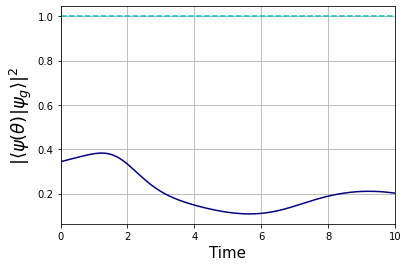

In [51]:
n = 1
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(1):
    plt.plot(time_domain,expt_value[kkk], color = colors[kkk])
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
#plt.legend()
plt.xlim(0,10)
#plt.ylim(0.99,1)

#plt.savefig("Imaginary_time_evolution_fidelity_3qutrits_M=0.1_N=2_comparison.pdf")

No handles with labels found to put in legend.


(0.0, 10.0)

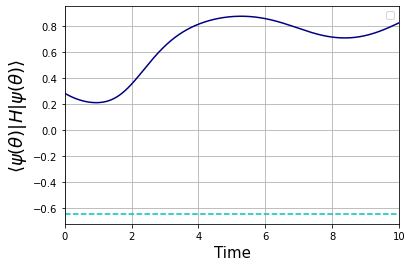

In [52]:
for kkk in range(1):
    plt.plot(time_domain,energyy[kkk], color = colors[kkk])
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_comparison.pdf")

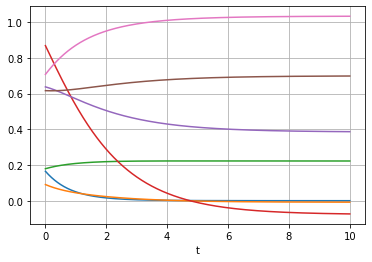

In [40]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [43]:
for i in range(coeff*N):
    print(Y[-1][i])

4.838222842295315e-06
-0.00822376007702962
0.22224045415837237
-0.07402449858619298
0.3864191038973874
0.6980257068843853
1.0326600859094566


In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

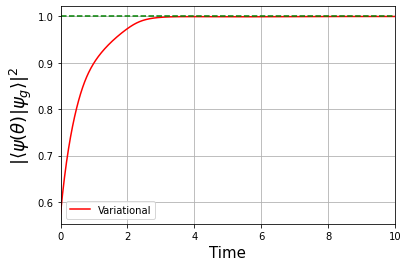

(0.0, 10.0)

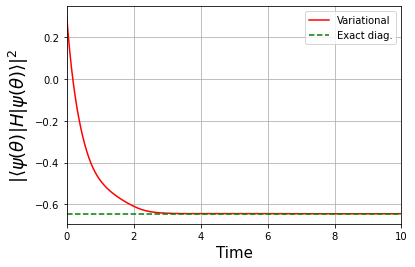

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
